##**Parte I: Exploración de la base de datos**

# Preparación:

Importamos librerías, funciones y los datasets con los que trabajaremos.

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import itertools
import os
import numpy as np
import pandas as pd
import scipy
import pathlib
from csv import reader
from scipy import signal
from scipy.signal import spectrogram
from pathlib import Path

In [ ]:
!git clone https://github.com/Francisco-Rua/Diplodatos-BCI.git
!mv Diplodatos-BCI/Datasets/* .
!mv "JA 1 - 2020 - 11-19.txt" "JA 1 - 2020-11-19.txt"

fatal: destination path 'Diplodatos-BCI' already exists and is not an empty directory.
mv: cannot stat 'Diplodatos-BCI/Datasets/*': No such file or directory
mv: cannot stat 'JA 1 - 2020 - 11-19.txt': No such file or directory


Definimos las funciones que nos va a ser útiles para trabajar nuestros datasets.

In [ ]:
# Útil

def has_metadata(csv_path):
    f = open(csv_path, newline='')
    csv_reader = reader(f)
    return True if next(csv_reader)[0] == '%OpenBCI Raw EEG Data' else False


def raw_read_bci_csv(csv_path):
    csv_reader = reader(open(csv_path, newline=''))
    n_lines = 10 if next(csv_reader)[0] == '%OpenBCI Raw EEG Data' else 0
    column_names = [
        'sample_index', 'ch0', 'ch1', 'ch2', 'ch3', 'acc0',
        'acc1', 'acc2', 'label', 'provided_time', 'timestamp'
    ]
    dataset = pd.read_csv(csv_path, skiprows=n_lines, index_col=False, names=column_names)
    sample_rate = 200.
    dataset['time'] = dataset.index.values/sample_rate
    return dataset


def clean_read_bci_csv(csv_path):
    dataset = raw_read_bci_csv(csv_path)
    dataset.drop(columns=['sample_index', 'acc0', 'acc1', 'acc2', 'provided_time', 'timestamp'], inplace=True)
    return dataset


def add_sub_label(dataset):
    labels = dataset.label.unique().tolist()
    for label in labels:
        sample_idx = dataset.loc[dataset.label == label].index.values
        gap_btn_idx = sample_idx[1:] - sample_idx[:-1]
        selected_idx = np.insert((gap_btn_idx != 1), 0, True)
        desired_idx_bottom = sample_idx[selected_idx]
        selected_idx = np.append(selected_idx[1:], True)
        desired_idx_top = sample_idx[selected_idx]
        for k, (start, stop) in enumerate(zip(desired_idx_bottom, desired_idx_top)):
            selection = (dataset.index.values >= start) & (dataset.index.values <= stop)
            dataset.loc[selection, 'sub_label'] = f'{label}-{k}'
    return dataset


def detrend_channels(dataset, mode='both', window=200):
    if mode in ['global', 'both']:
        detrend_global = dataset.copy()
    if mode in ['both', 'local']:
        detrend_local = dataset.copy()
    for subject in dataset.subject.unique():
        selection = (dataset.subject == subject)
        for session in dataset.loc[selection, 'session'].unique():
            selection2 = selection & (dataset.session == session)
            if mode in ['global', 'both']:
                for ch in ['ch0', 'ch1', 'ch2', 'ch3']:
                    y = dataset.loc[selection2, ch].values
                    detrend_global.loc[selection2, ch] = signal.detrend(y)
            if mode in ['both', 'local']:
                for ch in ['ch0', 'ch1', 'ch2', 'ch3']:
                    index = dataset.loc[selection2].index.tolist()
                    iters = [iter(index)] * window
                    for k, index_set in enumerate(itertools.zip_longest(*iters)):
                        if None in index_set:
                            index_set = list(filter(None, index_set))
                        selection3 = selection2 & dataset.index.isin(index_set)
                        y = dataset.loc[selection3, ch].values
                        detrend_local.loc[selection3, ch] = signal.detrend(y)
    if mode == 'global':
        return detrend_global
    if mode == 'local':
        return detrend_local
    else:
        return detrend_global, detrend_local


def read_all_datasets(csvs_path: Path):
    complete_dataset = pd.DataFrame()
    for csv_path in csvs_path.iterdir():
        dataset = clean_read_bci_csv(csv_path)
        dataset = add_sub_label(dataset)
        dataset['subject'] = csv_path.name[:2]
        dataset['session'] = csv_path.name[3]
        dataset['sub_sess'] = dataset.subject + '-' + dataset.session
        complete_dataset = pd.concat([complete_dataset, dataset])
    return complete_dataset

Se quitan los metadatos al comienzo de las bases. Conservaremos sólo las columnas 'ch0'	'ch1'	'ch2'	'ch3'	'label'	'time' que serán con las que vamos a trabajar.

Dichas columnas relevantes se corresponden con la siguiente información:

- Canal 1
- Canal 2
- Canal 3
- Canal 4
- Etiqueta
- Tiempo

In [ ]:
df_AA0 = clean_read_bci_csv('AA 0 - 2020-10-28.csv')
df_AA1 = clean_read_bci_csv('AA 1 - 2020-11-24.txt')
df_AA2 = clean_read_bci_csv('AA 2 - 2020-11-24.txt')
df_HA1 = clean_read_bci_csv('HA 1 - 2020-11-24.txt')
df_JA1 = clean_read_bci_csv('JA 1 - 2020-11-19.txt')
df_JA2 = clean_read_bci_csv('JA 2 - 2020-11-24.txt')
df_MA1 = clean_read_bci_csv('MA 1 - 2020-12-18.txt')

df_AA0

,ch0,ch1,ch2,ch3,label,time
0,-1.86,-12.95,-9.18,-41.36,99,0.000
1,10.77,3.47,6.87,-15.13,99,0.005
2,87.61,65.61,88.78,32.23,99,0.010
3,83.04,50.88,77.30,4.49,99,0.015
4,8.07,-20.55,-6.68,-38.09,99,0.020
...,...,...,...,...,...,...
45968,-15.69,-22.97,3.24,-75.01,99,229.840
45969,84.95,73.30,116.55,-5.97,99,229.845
45970,73.14,47.58,95.13,-36.34,99,229.850
45971,3.68,-20.26,13.70,-89.01,99,229.855


In [ ]:
df_AA0['time'].describe()

count    45973.000000
mean       114.930000
std         66.357031
min          0.000000
25%         57.465000
50%        114.930000
75%        172.395000
max        229.860000
Name: time, dtype: float64

Agregamos la columna "name" en cada df para identificar cada paciente y sesión 

In [ ]:
df_AA0['Name'] = 'AA0'
df_AA1['Name'] = 'AA1'
df_AA2['Name'] = 'AA2'
df_HA1['Name'] = 'HA1'
df_JA1['Name'] = 'JA1'
df_JA2['Name'] = 'JA2'
df_MA1['Name'] = 'MA1'
df_AA0

,ch0,ch1,ch2,ch3,label,time,Name
0,-1.86,-12.95,-9.18,-41.36,99,0.000,AA0
1,10.77,3.47,6.87,-15.13,99,0.005,AA0
2,87.61,65.61,88.78,32.23,99,0.010,AA0
3,83.04,50.88,77.30,4.49,99,0.015,AA0
4,8.07,-20.55,-6.68,-38.09,99,0.020,AA0
...,...,...,...,...,...,...,...
45968,-15.69,-22.97,3.24,-75.01,99,229.840,AA0
45969,84.95,73.30,116.55,-5.97,99,229.845,AA0
45970,73.14,47.58,95.13,-36.34,99,229.850,AA0
45971,3.68,-20.26,13.70,-89.01,99,229.855,AA0


In [ ]:
#Realizamos multiples append para unificar las bases en una única gran base

df_total = df_AA0
df_total = df_total.append(df_AA1, ignore_index=True)
df_total = df_total.append(df_AA2, ignore_index=True)
df_total = df_total.append(df_HA1, ignore_index=True)
df_total = df_total.append(df_JA1, ignore_index=True)
df_total = df_total.append(df_JA2, ignore_index=True)
df_total = df_total.append(df_MA1, ignore_index=True)
df_total
      

,ch0,ch1,ch2,ch3,label,time,Name
0,-1.86,-12.95,-9.18,-41.36,99,0.000,AA0
1,10.77,3.47,6.87,-15.13,99,0.005,AA0
2,87.61,65.61,88.78,32.23,99,0.010,AA0
3,83.04,50.88,77.30,4.49,99,0.015,AA0
4,8.07,-20.55,-6.68,-38.09,99,0.020,AA0
...,...,...,...,...,...,...,...
659107,805.10,36.59,1370.61,1342.16,99,348.525,MA1
659108,809.05,27.30,1378.69,1340.12,99,348.530,MA1
659109,818.05,27.28,1384.75,1345.36,99,348.535,MA1
659110,810.54,31.55,1373.65,1334.40,99,348.540,MA1


In [ ]:
df_total.dtypes

ch0      float64
ch1      float64
ch2      float64
ch3      float64
label      int64
time     float64
Name      object
dtype: object

In [ ]:
df_total.isna().sum()

ch0      0
ch1      0
ch2      0
ch3      0
label    0
time     0
Name     0
dtype: int64

In [ ]:
df_group_by = df_total.groupby(by='Name').describe()
df_group_by


ch0                                                          \
         count         mean          std       min        25%      50%   
Name                                                                     
AA0    45973.0    42.909730    48.323405    -68.08    -2.3400    42.05   
AA1   138169.0  1893.364893    87.373496   1405.36  1836.4400  1887.77   
AA2   110384.0  1804.791545    80.020462   1169.73  1757.8775  1811.69   
HA1   137693.0  1948.115979   117.341618   1447.95  1858.7600  1951.09   
JA1    55860.0  2628.013230    36.829804   2513.50  2596.0900  2632.85   
JA2   101323.0  1811.609237  2993.883938 -32227.04  1884.5900  2035.53   
MA1    69710.0   767.115006    32.751965    595.30   744.3600   761.19   

                               ch1               ... label            time  \
           75%       max     count         mean  ...   75%   max     count   
Name                                             ...                         
AA0     88.170    185.65   45973.0    25.580902  ...  99.0  99.0   45973.0   
AA1   1956.750   2301.03  138169.0   952.766675  ...  99.0  99.0  138169.0   
AA2   1870.300   1997.81  110384.0   934.512669  ...  99.0  99.0  110384.0   
HA1   2041.580   2510.05  137693.0   940.505374  ...  99.0  99.0  137693.0   
JA1   2659.390   2721.30   55860.0  2683.621456  ...  99.0  99.0   55860.0   
JA2   2134.035  30263.94  101323.0  1237.903700  ...  99.0  99.0  101323.0   
MA1    792.700   1020.49   69710.0    13.201465  ...  99.0  99.0   69710.0   

                                                                          
          mean         std  min        25%       50%        75%      max  
Name                                                                      
AA0   114.9300   66.357031  0.0   57.46500  114.9300  172.39500  229.860  
AA1   345.4200  199.430495  0.0  172.71000  345.4200  518.13000  690.840  
AA2   275.9575  159.326302  0.0  137.97875  275.9575  413.93625  551.915  
HA1   344.2300  198.743448  0.0  172.11500  344.2300  516.34500  688.460  
JA1   139.6475   80.627687  0.0   69.82375  139.6475  209.47125  279.295  
JA2   253.3050  146.247875  0.0  126.65250  253.3050  379.95750  506.610  
MA1   174.2725  100.618440  0.0   87.13625  174.2725  261.40875  348.545  

[7 rows x 48 columns]

In [ ]:
df_group_by['ch0']

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
AA0,45973.0,42.909730,48.323405,-68.08,-2.3400,42.05,88.170,185.65
AA1,138169.0,1893.364893,87.373496,1405.36,1836.4400,1887.77,1956.750,2301.03
AA2,110384.0,1804.791545,80.020462,1169.73,1757.8775,1811.69,1870.300,1997.81
HA1,137693.0,1948.115979,117.341618,1447.95,1858.7600,1951.09,2041.580,2510.05
JA1,55860.0,2628.013230,36.829804,2513.50,2596.0900,2632.85,2659.390,2721.30
JA2,101323.0,1811.609237,2993.883938,-32227.04,1884.5900,2035.53,2134.035,30263.94
MA1,69710.0,767.115006,32.751965,595.30,744.3600,761.19,792.700,1020.49


In [ ]:
df_group_by['ch1']

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
AA0,45973.0,25.580902,45.253793,-81.20,-16.8800,25.45,67.9400,167.98
AA1,138169.0,952.766675,82.635437,451.28,894.6200,956.59,1018.1200,1471.02
AA2,110384.0,934.512669,125.699366,404.38,858.7375,944.71,1048.3100,1164.17
HA1,137693.0,940.505374,126.891675,352.98,848.1800,952.04,1049.5000,1976.22
JA1,55860.0,2683.621456,39.377337,2566.10,2648.3000,2687.62,2718.1325,2777.15
JA2,101323.0,1237.903700,3246.321507,-27065.99,1163.3100,1275.97,1359.3600,44839.75
MA1,69710.0,13.201465,20.904099,-165.47,4.8700,17.01,26.0700,197.02


In [ ]:
df_group_by['ch2']

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
AA0,45973.0,50.757091,51.727307,-69.52,1.80,50.080,99.97,195.35
AA1,138169.0,2085.313585,96.557309,1397.52,2005.37,2090.120,2165.67,2681.03
AA2,110384.0,1979.625920,118.329141,1652.68,1894.77,1974.335,2096.76,2209.60
HA1,137693.0,1909.010736,112.760085,1498.13,1816.18,1921.040,2004.50,2377.93
JA1,55860.0,2761.907642,29.052220,2669.52,2735.72,2764.530,2786.73,2845.01
JA2,101323.0,1965.096143,2465.189182,-30160.93,2028.16,2146.090,2235.77,23036.75
MA1,69710.0,1349.069226,25.189665,801.83,1333.70,1347.490,1365.02,1629.64


In [ ]:
df_group_by['ch3']

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
AA0,45973.0,-27.097523,38.634887,-163.35,-60.5000,-26.41,5.8400,100.82
AA1,138169.0,1901.377143,61.505431,1513.07,1865.3900,1912.18,1944.8600,2319.12
AA2,110384.0,1915.280790,94.458094,1581.10,1853.9700,1920.16,1997.4925,2106.48
HA1,137693.0,1983.256555,126.710505,1546.78,1878.7100,1995.11,2087.1700,2340.99
JA1,55860.0,2692.545311,30.666869,2600.51,2665.4175,2696.63,2718.6800,2773.50
JA2,101323.0,1781.406057,3039.527492,-46913.84,1905.8600,2037.17,2144.6300,25123.48
MA1,69710.0,1293.501130,34.407538,1088.94,1266.1700,1280.15,1325.2000,1442.04


In [ ]:
df_group_by['label']

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
AA0,45973.0,36.546342,46.786582,1.0,1.0,2.0,99.0,99.0
AA1,138169.0,61.931721,47.322963,1.0,2.0,99.0,99.0,99.0
AA2,110384.0,63.714497,46.845010,1.0,2.0,99.0,99.0,99.0
HA1,137693.0,70.708504,44.242037,1.0,2.0,99.0,99.0,99.0
JA1,55860.0,54.943305,48.525324,1.0,2.0,99.0,99.0,99.0
JA2,101323.0,60.590873,47.631215,1.0,2.0,99.0,99.0,99.0
MA1,69710.0,63.674236,46.866583,1.0,2.0,99.0,99.0,99.0


In [ ]:
df_group_by['time']

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
AA0,45973.0,114.9300,66.357031,0.0,57.46500,114.9300,172.39500,229.860
AA1,138169.0,345.4200,199.430495,0.0,172.71000,345.4200,518.13000,690.840
AA2,110384.0,275.9575,159.326302,0.0,137.97875,275.9575,413.93625,551.915
HA1,137693.0,344.2300,198.743448,0.0,172.11500,344.2300,516.34500,688.460
JA1,55860.0,139.6475,80.627687,0.0,69.82375,139.6475,209.47125,279.295
JA2,101323.0,253.3050,146.247875,0.0,126.65250,253.3050,379.95750,506.610
MA1,69710.0,174.2725,100.618440,0.0,87.13625,174.2725,261.40875,348.545


### D -

Todos los canales para el sujeto AA1




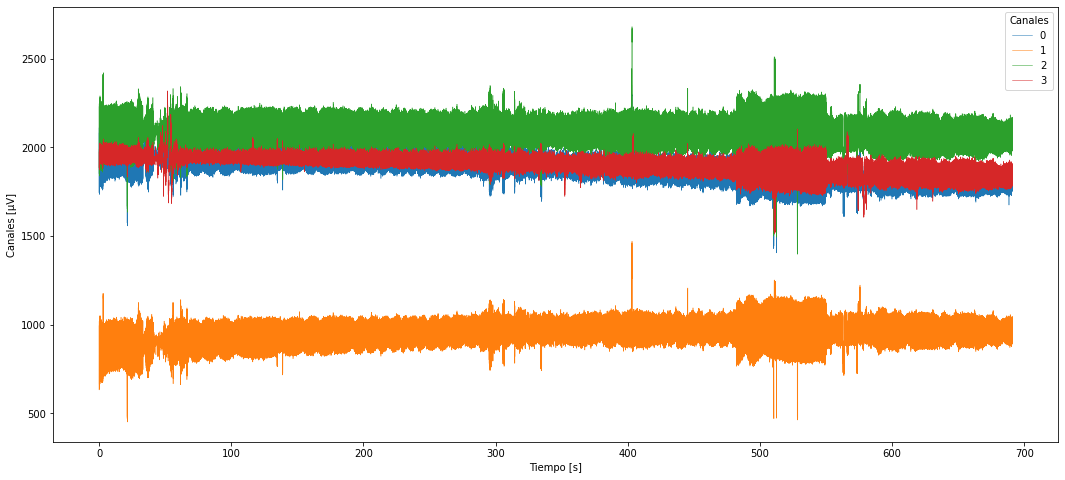

In [ ]:
plt.figure(figsize=(18, 8))

canales = ['0', '1', '2', '3']

for i in canales:
  fig = seaborn.lineplot(data=df_AA1, y=f"ch{i}", x="time", palette="tab10", linewidth=0.5)
  
fig.set_xlabel("Tiempo [s]")
fig.set_ylabel(f"Canales [µV]")
fig.legend(title='Canales', labels=canales)


Todos los sujetos un canal

In [ ]:
df_plot = df_total[['ch1','Name','time','label']].copy()
df_plot

,ch1,Name,time,label
0,-12.95,AA0,0.000,99
1,3.47,AA0,0.005,99
2,65.61,AA0,0.010,99
3,50.88,AA0,0.015,99
4,-20.55,AA0,0.020,99
...,...,...,...,...
659107,36.59,MA1,348.525,99
659108,27.30,MA1,348.530,99
659109,27.28,MA1,348.535,99
659110,31.55,MA1,348.540,99


In [ ]:
df_plot_ch1 = [(df_plot[df_plot['Name'] == 'AA0'], 'AA0'),
               (df_plot[df_plot['Name'] == 'HA1'], 'HA1'),
               (df_plot[df_plot['Name'] == 'JA1'], 'JA1'),
               (df_plot[df_plot['Name'] == 'MA1'], 'MA1')]
df_plot_ch1

[(         ch1 Name     time  label
  0     -12.95  AA0    0.000     99
  1       3.47  AA0    0.005     99
  2      65.61  AA0    0.010     99
  3      50.88  AA0    0.015     99
  4     -20.55  AA0    0.020     99
  ...      ...  ...      ...    ...
  45968 -22.97  AA0  229.840     99
  45969  73.30  AA0  229.845     99
  45970  47.58  AA0  229.850     99
  45971 -20.26  AA0  229.855     99
  45972 -39.20  AA0  229.860     99
  
  [45973 rows x 4 columns], 'AA0'), (            ch1 Name     time  label
  294526   771.75  HA1    0.000     99
  294527   706.07  HA1    0.005     99
  294528   806.13  HA1    0.010     99
  294529   840.87  HA1    0.015     99
  294530   753.03  HA1    0.020     99
  ...         ...  ...      ...    ...
  432214  1176.88  HA1  688.440     99
  432215  1168.73  HA1  688.445     99
  432216  1152.47  HA1  688.450     99
  432217  1159.43  HA1  688.455     99
  432218  1177.42  HA1  688.460     99
  
  [137693 rows x 4 columns], 'HA1'), (            ch1 Name 

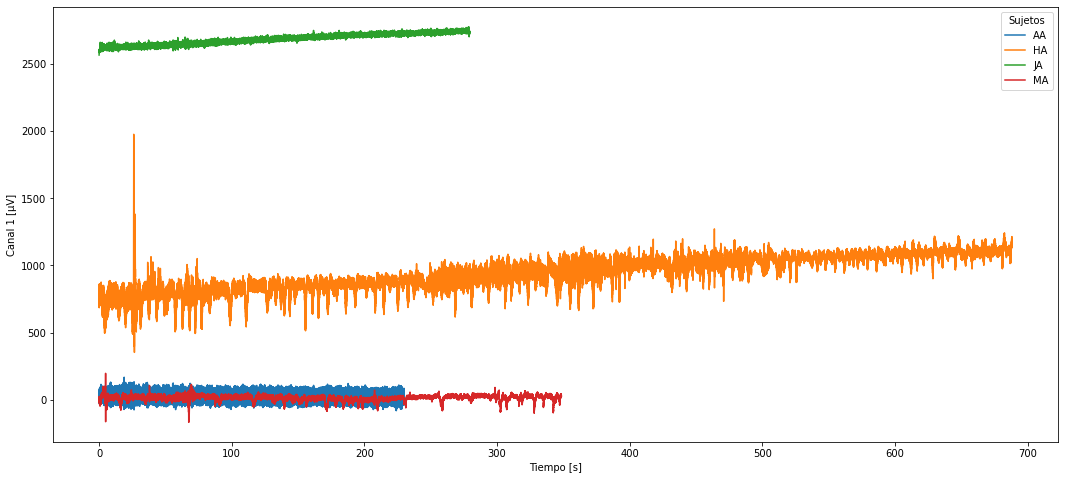

In [ ]:
plt.figure(figsize=(18, 8))

sujetos = ['AA', 'HA', 'JA', 'MA']

for i in range(4):
  fig =seaborn.lineplot(data = df_plot_ch1[i][0], x="time",y="ch1")
  
fig.set_xlabel("Tiempo [s]")
fig.set_ylabel("Canal 1 [µV]")
fig.legend(title='Sujetos', labels=sujetos)

Mismo sujeto, mismo canal, diferentes sesiones

In [ ]:
df_plot_ch1_aa = [(df_plot[df_plot['Name'] == 'AA0'], 'AA0'),
               (df_plot[df_plot['Name'] == 'AA1'], 'AA1'),
               (df_plot[df_plot['Name'] == 'AA2'], 'AA2'),]
df_plot_ch1_aa

[(         ch1 Name     time  label
  0     -12.95  AA0    0.000     99
  1       3.47  AA0    0.005     99
  2      65.61  AA0    0.010     99
  3      50.88  AA0    0.015     99
  4     -20.55  AA0    0.020     99
  ...      ...  ...      ...    ...
  45968 -22.97  AA0  229.840     99
  45969  73.30  AA0  229.845     99
  45970  47.58  AA0  229.850     99
  45971 -20.26  AA0  229.855     99
  45972 -39.20  AA0  229.860     99
  
  [45973 rows x 4 columns], 'AA0'), (            ch1 Name     time  label
  45973    994.82  AA1    0.000     99
  45974    836.23  AA1    0.005     99
  45975    650.03  AA1    0.010     99
  45976    848.86  AA1    0.015     99
  45977    980.78  AA1    0.020     99
  ...         ...  ...      ...    ...
  184137  1034.31  AA1  690.820     99
  184138   952.31  AA1  690.825     99
  184139   891.24  AA1  690.830     99
  184140   984.00  AA1  690.835     99
  184141  1026.24  AA1  690.840     99
  
  [138169 rows x 4 columns], 'AA1'), (            ch1 Name 

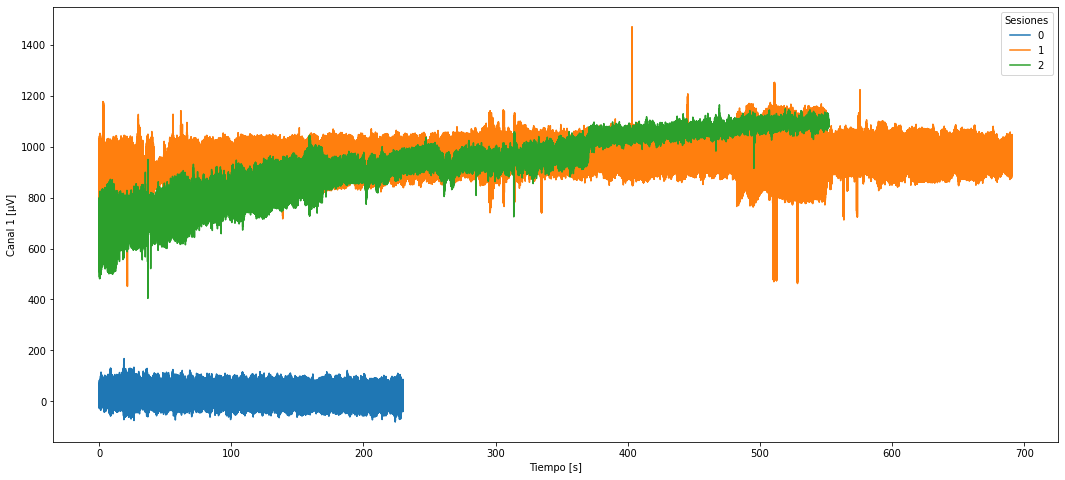

In [ ]:
plt.figure(figsize=(18, 8))

sesiones = ['0', '1', '2']

for i in range(3):
  fig =seaborn.lineplot(data = df_plot_ch1_aa[i][0], x="time",y="ch1")
  
fig.set_xlabel("Tiempo [s]")
fig.set_ylabel("Canal 1 [µV]")
fig.legend(title='Sesiones', labels=sesiones)

Un mismo estado - diferentes sujetos

In [ ]:
df_AA0.label.unique()

array([99,  2,  1])

In [ ]:
df_plot_label_1_aux = df_plot[df_plot['label'] == 1]
                       
df_plot_label_1 = [(df_plot_label_1_aux[df_plot_label_1_aux['Name'] == 'AA0'], 'AA0'),
               (df_plot_label_1_aux[df_plot_label_1_aux['Name'] == 'HA1'], 'HA1'),
               (df_plot_label_1_aux[df_plot_label_1_aux['Name'] == 'JA1'], 'JA1'),
               (df_plot_label_1_aux[df_plot_label_1_aux['Name'] == 'MA1'], 'MA1')]

df_plot_label_1

[(         ch1 Name     time  label
  11387  21.16  AA0   56.935      1
  11388  74.41  AA0   56.940      1
  11389  30.47  AA0   56.945      1
  11390 -36.82  AA0   56.950      1
  11391   3.35  AA0   56.955      1
  ...      ...  ...      ...    ...
  44829 -12.76  AA0  224.145      1
  44830  56.76  AA0  224.150      1
  44831  -7.27  AA0  224.155      1
  44832 -59.23  AA0  224.160      1
  44833   6.83  AA0  224.165      1
  
  [14726 rows x 4 columns], 'AA0'), (            ch1 Name     time  label
  317624   819.74  HA1  115.490      1
  317625   812.60  HA1  115.495      1
  317626   867.93  HA1  115.500      1
  317627   860.20  HA1  115.505      1
  317628   826.94  HA1  115.510      1
  ...         ...  ...      ...    ...
  431711  1132.50  HA1  685.925      1
  431712  1103.94  HA1  685.930      1
  431713  1084.58  HA1  685.935      1
  431714  1114.31  HA1  685.940      1
  431715  1136.09  HA1  685.945      1
  
  [18936 rows x 4 columns], 'HA1'), (            ch1 Name  

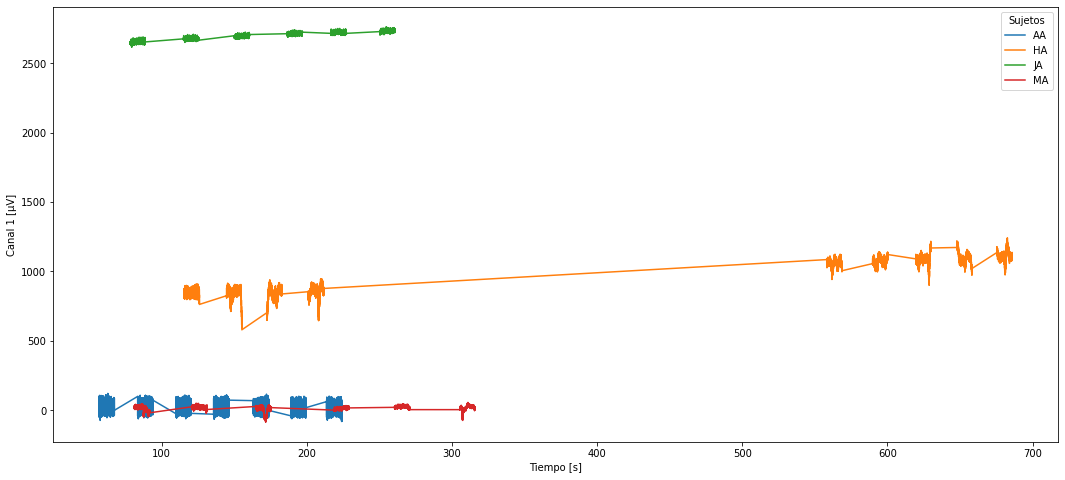

In [ ]:
plt.figure(figsize=(18, 8))

sujetos = ['AA', 'HA', 'JA', 'MA']

for i in range(4):
  fig =seaborn.lineplot(data = df_plot_label_1[i][0], x="time",y="ch1")
  
fig.set_xlabel("Tiempo [s]")
fig.set_ylabel("Canal 1 [µV]")
fig.legend(title='Sujetos', labels=sujetos)

Un mismo sujeto y canal - diferentes estados

In [ ]:
df_plot_label_aa_1_aux = df_plot[df_plot['Name'] == 'AA1']
                       
df_plot_label_aa_1 = [(df_plot_label_aa_1_aux[df_plot_label_aa_1_aux['label'] == 1], 'AA0-Estado-1'),
                      (df_plot_label_aa_1_aux[df_plot_label_aa_1_aux['label'] == 2], 'AA0-Estado-2'),
                      (df_plot_label_aa_1_aux[df_plot_label_aa_1_aux['label'] == 99], 'AA0-Estado-99')]

df_plot_label_aa_1

[(            ch1 Name     time  label
  64115    994.21  AA1   90.710      1
  64116    856.17  AA1   90.715      1
  64117    864.23  AA1   90.720      1
  64118   1018.17  AA1   90.725      1
  64119    969.74  AA1   90.730      1
  ...         ...  ...      ...    ...
  180951   983.29  AA1  674.890      1
  180952   893.98  AA1  674.895      1
  180953   938.35  AA1  674.900      1
  180954  1044.65  AA1  674.905      1
  180955   985.89  AA1  674.910      1
  
  [25210 rows x 4 columns], 'AA0-Estado-1'),
 (            ch1 Name     time  label
  60962    814.71  AA1   74.945      2
  60963    969.21  AA1   74.950      2
  60964   1025.39  AA1   74.955      2
  60965    910.16  AA1   74.960      2
  60966    824.23  AA1   74.965      2
  ...         ...  ...      ...    ...
  183868   965.17  AA1  689.475      2
  183869  1036.79  AA1  689.480      2
  183870   970.61  AA1  689.485      2
  183871   904.75  AA1  689.490      2
  183872   982.83  AA1  689.495      2
  
  [27331 rows

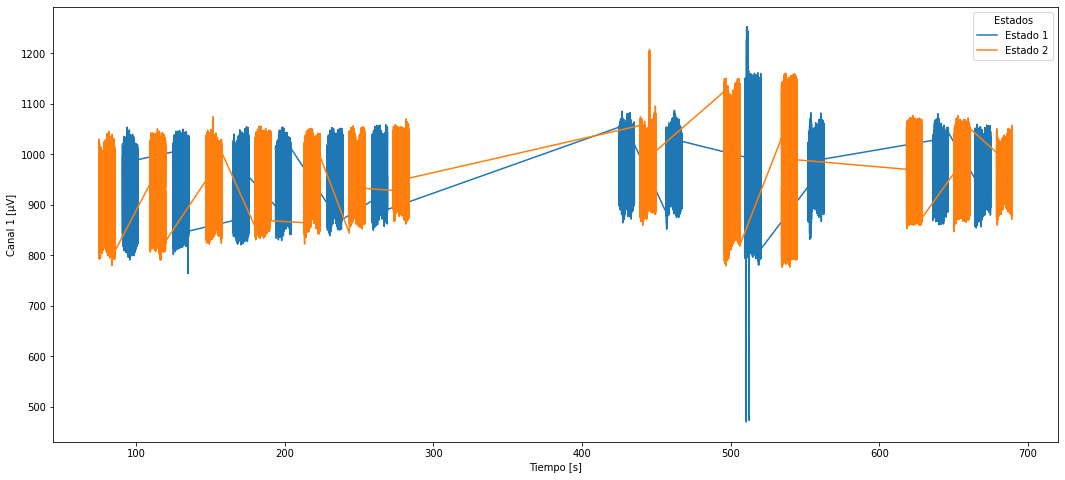

In [ ]:
plt.figure(figsize=(18, 8))

estados = ['Estado 1', 'Estado 2','Estado 99']

for i in range(2):
  fig =seaborn.lineplot(data = df_plot_label_aa_1[i][0], x="time",y="ch1")
  
fig.set_xlabel("Tiempo [s]")
fig.set_ylabel("Canal 1 [µV]")
fig.legend(title='Estados', labels=estados)

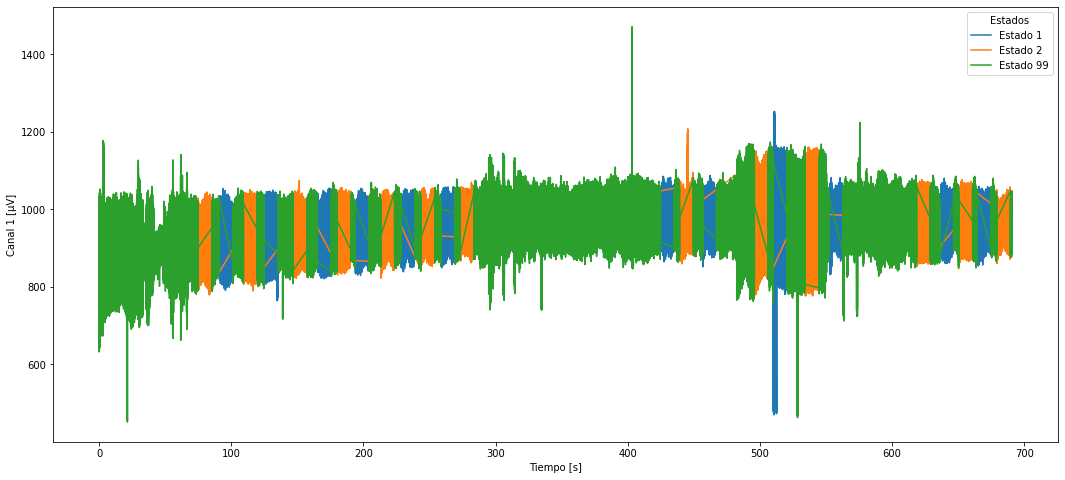

In [ ]:
plt.figure(figsize=(18, 8))

estados = ['Estado 1', 'Estado 2','Estado 99']

for i in range(3):
  fig =seaborn.lineplot(data = df_plot_label_aa_1[i][0], x="time",y="ch1")
  
fig.set_xlabel("Tiempo [s]")
fig.set_ylabel("Canal 1 [µV]")
fig.legend(title='Estados', labels=estados)

In [ ]:
df_plot_label_aa_1_ch0 =  df_AA1[['ch0','Name','time','label']]
df_plot_label_aa_1_ch0

,ch0,Name,time,label
0,2081.61,AA1,0.000,99
1,1926.57,AA1,0.005,99
2,1744.17,AA1,0.010,99
3,1937.29,AA1,0.015,99
4,2079.86,AA1,0.020,99
...,...,...,...,...
138164,1854.27,AA1,690.820,99
138165,1791.11,AA1,690.825,99
138166,1751.95,AA1,690.830,99
138167,1832.42,AA1,690.835,99


In [ ]:
df_plot_label_aa_1_ch0 = [(df_plot_label_aa_1_ch0[df_plot_label_aa_1_ch0['label'] == 1], 'AA0-Estado-1'),
                      (df_plot_label_aa_1_ch0[df_plot_label_aa_1_ch0['label'] == 2], 'AA0-Estado-2'),
                      (df_plot_label_aa_1_ch0[df_plot_label_aa_1_ch0['label'] == 99], 'AA0-Estado-99')]

df_plot_label_aa_1_ch0

[(            ch0 Name     time  label
  18142   2017.35  AA1   90.710      1
  18143   1892.06  AA1   90.715      1
  18144   1897.35  AA1   90.720      1
  18145   2050.41  AA1   90.725      1
  18146   2006.42  AA1   90.730      1
  ...         ...  ...      ...    ...
  134978  1814.09  AA1  674.890      1
  134979  1750.36  AA1  674.895      1
  134980  1788.56  AA1  674.900      1
  134981  1864.28  AA1  674.905      1
  134982  1813.57  AA1  674.910      1
  
  [25210 rows x 4 columns], 'AA0-Estado-1'),
 (            ch0 Name     time  label
  14989   1856.34  AA1   74.945      2
  14990   2001.61  AA1   74.950      2
  14991   2056.79  AA1   74.955      2
  14992   1950.08  AA1   74.960      2
  14993   1878.17  AA1   74.965      2
  ...         ...  ...      ...    ...
  137895  1810.48  AA1  689.475      2
  137896  1856.70  AA1  689.480      2
  137897  1793.54  AA1  689.485      2
  137898  1750.04  AA1  689.490      2
  137899  1817.94  AA1  689.495      2
  
  [27331 rows

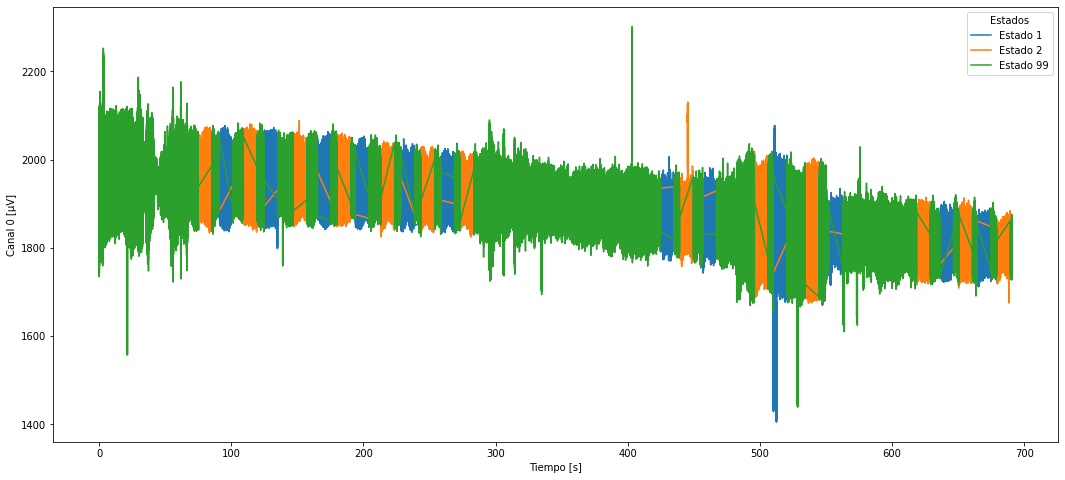

In [ ]:
plt.figure(figsize=(18, 8))

estados = ['Estado 1', 'Estado 2','Estado 99']

for i in range(3):
  fig =seaborn.lineplot(data = df_plot_label_aa_1_ch0[i][0], x="time",y="ch0")
  
fig.set_xlabel("Tiempo [s]")
fig.set_ylabel("Canal 0 [µV]")
fig.legend(title='Estados', labels=estados)

In [ ]:
df_AA1


,ch0,ch1,ch2,ch3,label,time,Name
0,2081.61,994.82,2229.93,1975.38,99,0.000,AA1
1,1926.57,836.23,2065.95,1912.34,99,0.005,AA1
2,1744.17,650.03,1852.65,1883.84,99,0.010,AA1
3,1937.29,848.86,2050.07,1970.17,99,0.015,AA1
4,2079.86,980.78,2222.84,1981.65,99,0.020,AA1
...,...,...,...,...,...,...,...
138164,1854.27,1034.31,2152.96,1811.63,99,690.820,AA1
138165,1791.11,952.31,2071.41,1781.04,99,690.825,AA1
138166,1751.95,891.24,1981.05,1860.84,99,690.830,AA1
138167,1832.42,984.00,2070.59,1905.69,99,690.835,AA1


In [ ]:
df_plot_label_aa_1_ch2 =  df_AA1[['ch2','Name','time','label']]
df_plot_label_aa_1_ch2 = [(df_plot_label_aa_1_ch2[df_plot_label_aa_1_ch2['label'] == 1], 'AA0-Estado-1'),
                      (df_plot_label_aa_1_ch2[df_plot_label_aa_1_ch2['label'] == 2], 'AA0-Estado-2'),
                      (df_plot_label_aa_1_ch2[df_plot_label_aa_1_ch2['label'] == 99], 'AA0-Estado-99')]

df_plot_label_aa_1_ch2

[(            ch2 Name     time  label
  18142   2184.45  AA1   90.710      1
  18143   2027.05  AA1   90.715      1
  18144   2012.36  AA1   90.720      1
  18145   2200.88  AA1   90.725      1
  18146   2166.91  AA1   90.730      1
  ...         ...  ...      ...    ...
  134978  2116.88  AA1  674.890      1
  134979  1987.07  AA1  674.895      1
  134980  2000.56  AA1  674.900      1
  134981  2148.57  AA1  674.905      1
  134982  2112.81  AA1  674.910      1
  
  [25210 rows x 4 columns], 'AA0-Estado-1'),
 (            ch2 Name     time  label
  14989   1963.03  AA1   74.945      2
  14990   2124.29  AA1   74.950      2
  14991   2207.91  AA1   74.955      2
  14992   2086.71  AA1   74.960      2
  14993   1980.16  AA1   74.965      2
  ...         ...  ...      ...    ...
  137895  2036.72  AA1  689.475      2
  137896  2148.47  AA1  689.480      2
  137897  2082.27  AA1  689.485      2
  137898  1989.25  AA1  689.490      2
  137899  2056.13  AA1  689.495      2
  
  [27331 rows

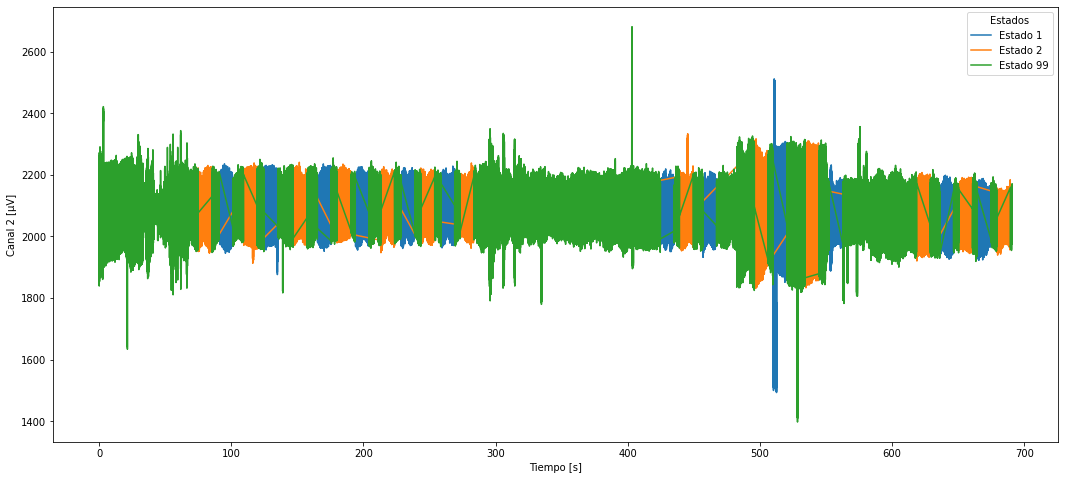

In [ ]:
plt.figure(figsize=(18, 8))

estados = ['Estado 1', 'Estado 2','Estado 99']

for i in range(3):
  fig =seaborn.lineplot(data = df_plot_label_aa_1_ch2[i][0], x="time",y="ch2")
  
fig.set_xlabel("Tiempo [s]")
fig.set_ylabel("Canal 2 [µV]")
fig.legend(title='Estados', labels=estados)

In [ ]:
df_plot_label_aa_1_ch3 =  df_AA1[['ch3','Name','time','label']]
df_plot_label_aa_1_ch3 = [(df_plot_label_aa_1_ch3[df_plot_label_aa_1_ch3['label'] == 1], 'AA0-Estado-1'),
                      (df_plot_label_aa_1_ch3[df_plot_label_aa_1_ch3['label'] == 2], 'AA0-Estado-2'),
                      (df_plot_label_aa_1_ch3[df_plot_label_aa_1_ch3['label'] == 99], 'AA0-Estado-99')]

df_plot_label_aa_1_ch3

[(            ch3 Name     time  label
  18142   1935.56  AA1   90.710      1
  18143   1937.76  AA1   90.715      1
  18144   1974.45  AA1   90.720      1
  18145   1972.51  AA1   90.725      1
  18146   1925.25  AA1   90.730      1
  ...         ...  ...      ...    ...
  134978  1773.57  AA1  674.890      1
  134979  1828.87  AA1  674.895      1
  134980  1912.68  AA1  674.900      1
  134981  1840.87  AA1  674.905      1
  134982  1773.39  AA1  674.910      1
  
  [25210 rows x 4 columns], 'AA0-Estado-1'),
 (            ch3 Name     time  label
  14989   1954.19  AA1   74.945      2
  14990   1982.02  AA1   74.950      2
  14991   1946.17  AA1   74.955      2
  14992   1927.24  AA1   74.960      2
  14993   1959.01  AA1   74.965      2
  ...         ...  ...      ...    ...
  137895  1895.53  AA1  689.475      2
  137896  1816.94  AA1  689.480      2
  137897  1777.02  AA1  689.485      2
  137898  1848.95  AA1  689.490      2
  137899  1905.84  AA1  689.495      2
  
  [27331 rows

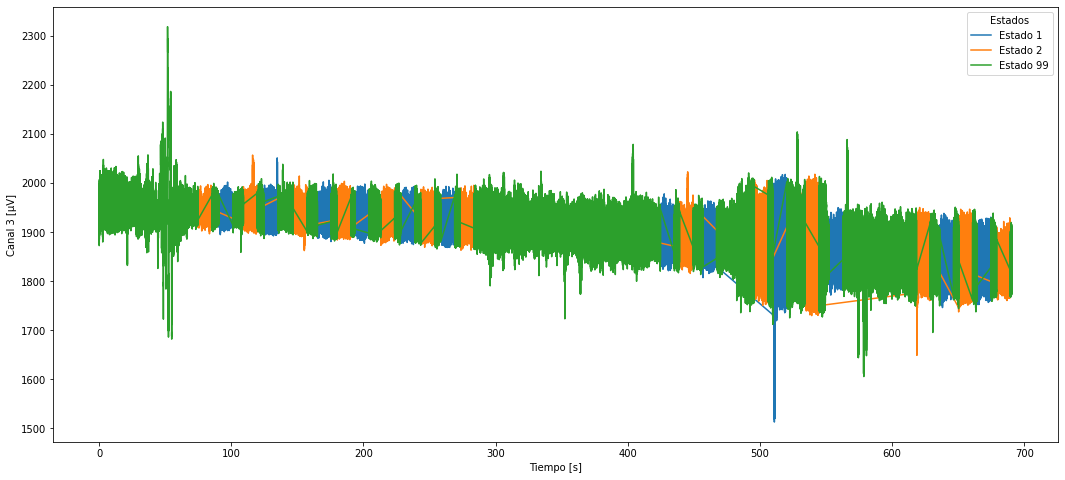

In [ ]:
plt.figure(figsize=(18, 8))

estados = ['Estado 1', 'Estado 2','Estado 99']

for i in range(3):
  fig =seaborn.lineplot(data = df_plot_label_aa_1_ch3[i][0], x="time",y="ch3")
  
fig.set_xlabel("Tiempo [s]")
fig.set_ylabel("Canal 3 [µV]")
fig.legend(title='Estados', labels=estados)

# Parte II: Dominio de tiempo

## A -  Nivel Segmento/Estado: 
Seleccione los datos correspondientes a un paciente y un canal, y para él defina un conjunto de señales para cada estado presente en el dataset. Para cada uno de ellos estudie los siguientes elementos y luego compárelos.




In [ ]:
df_AA1_ch1 = df_AA1[['ch1','time','label']]
df_AA1_ch1

,ch1,time,label
0,994.82,0.000,99
1,836.23,0.005,99
2,650.03,0.010,99
3,848.86,0.015,99
4,980.78,0.020,99
...,...,...,...
138164,1034.31,690.820,99
138165,952.31,690.825,99
138166,891.24,690.830,99
138167,984.00,690.835,99


### a) ¿Presenta los valores de voltaje una distribución normal? Utilizar un criterio gráfico y un test para probarlo. Si la distribución normal no se ajusta, ¿a qué distribución se asemejan? 



Seleccionamos para cada estados del mismo sujeto y canal el intervalo de tiempo correspondiente a los primeros 30 segundos de toma de la muestra de cada estímulo.

In [ ]:

estados = ['Estado 1', 'Estado 2','Estado 99']
df_AA1_ch1_1 = df_AA1_ch1[df_AA1_ch1['label'] == 1 ]
df_AA1_ch1_2 = df_AA1_ch1[df_AA1_ch1['label'] == 2 ]
df_AA1_ch1_99 = df_AA1_ch1[df_AA1_ch1['label'] == 99 ]

df_AA1_ch1_99_short = df_AA1_ch1_99[0:6000]
df_AA1_ch1_1_short = df_AA1_ch1_1[0:6000]
df_AA1_ch1_2_short= df_AA1_ch1_2[0:6000]

print (df_AA1_ch1_2_short)


           ch1     time  label
14989   814.71   74.945      2
14990   969.21   74.950      2
14991  1025.39   74.955      2
14992   910.16   74.960      2
14993   824.23   74.965      2
...        ...      ...    ...
31173   885.87  155.865      2
31174   854.02  155.870      2
31175  1008.27  155.875      2
31176  1009.34  155.880      2
31177   896.84  155.885      2

[6000 rows x 3 columns]


Text(0.5, 0, '[µV]')

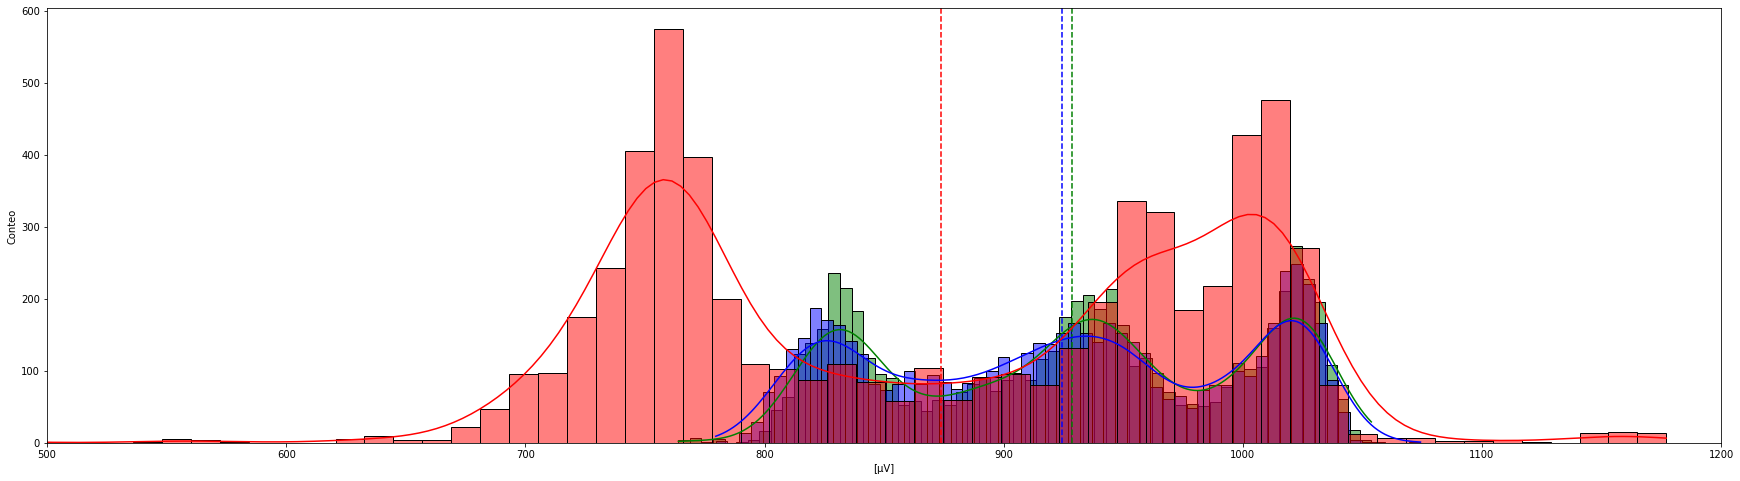

In [ ]:
plt.figure(figsize=(30, 8))

estados = ['Estado 1', 'Estado 2','Estado 99']
df_AA1_ch1_1 = df_AA1_ch1[df_AA1_ch1['label'] == 1 ]
df_AA1_ch1_2 = df_AA1_ch1[df_AA1_ch1['label'] == 2 ]
df_AA1_ch1_99 = df_AA1_ch1[df_AA1_ch1['label'] == 99 ]

df_AA1_ch1_99_short = df_AA1_ch1_99[0:6000]
df_AA1_ch1_1_short = df_AA1_ch1_1[0:6000]
df_AA1_ch1_2_short= df_AA1_ch1_2[0:6000]

df_plot_hist = [(df_AA1_ch1_1_short, 'AA-1'),(df_AA1_ch1_2_short, 'AA-2'),(df_AA1_ch1_99_short, 'AA-99')]

color_list = ('g','b','r')

for i in range(3):
  fig = seaborn.histplot(df_plot_hist[i][0], x="ch1", bins = 60 , kde=True, color=color_list[i])
  df_medias = df_plot_hist[i][0]
  fig.axvline(df_medias.ch1.mean(), color=color_list[i], linestyle='--')

fig.set(xlim=(500, 1200))
fig.set_ylabel("Conteo")
fig.set_xlabel("[µV]")

In [ ]:
df_short_total = df_AA1_ch1_1_short
df_short_total = df_short_total.append(df_AA1_ch1_2_short, ignore_index=True)
df_short_total = df_short_total.append(df_AA1_ch1_99_short, ignore_index= True)
print (df_short_total)


           ch1    time  label
0       994.21  90.710      1
1       856.17  90.715      1
2       864.23  90.720      1
3      1018.17  90.725      1
4       969.74  90.730      1
...        ...     ...    ...
17995  1063.10  29.975     99
17996   959.52  29.980     99
17997   723.09  29.985     99
17998   769.60  29.990     99
17999  1062.61  29.995     99

[18000 rows x 3 columns]


Probamos el conjunto total de señales con otros pacientes

In [ ]:
df_MA1_ch1 = df_MA1[['ch1','time','label']]
print(df_MA1_ch1)

         ch1     time  label
0      -9.85    0.000     99
1      -6.43    0.005     99
2      16.29    0.010     99
3      14.78    0.015     99
4       0.03    0.020     99
...      ...      ...    ...
69705  36.59  348.525     99
69706  27.30  348.530     99
69707  27.28  348.535     99
69708  31.55  348.540     99
69709  29.78  348.545     99

[69710 rows x 3 columns]


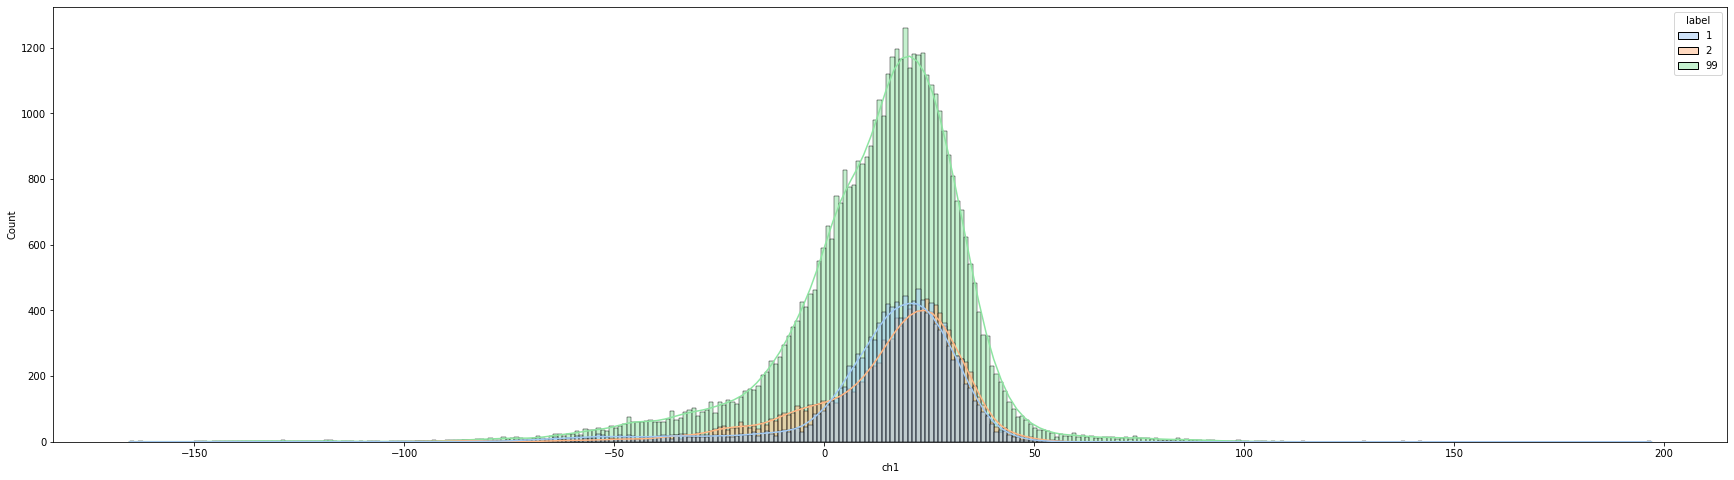

In [ ]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 8))

fig = sns.histplot(df_MA1_ch1, x= 'ch1', hue= 'label', kde= True, palette= 'pastel')
plt.show()

In [ ]:
df_HA1_ch1 = df_HA1[['ch1','time','label']]
print(df_HA1_ch1)

            ch1     time  label
0        771.75    0.000     99
1        706.07    0.005     99
2        806.13    0.010     99
3        840.87    0.015     99
4        753.03    0.020     99
...         ...      ...    ...
137688  1176.88  688.440     99
137689  1168.73  688.445     99
137690  1152.47  688.450     99
137691  1159.43  688.455     99
137692  1177.42  688.460     99

[137693 rows x 3 columns]


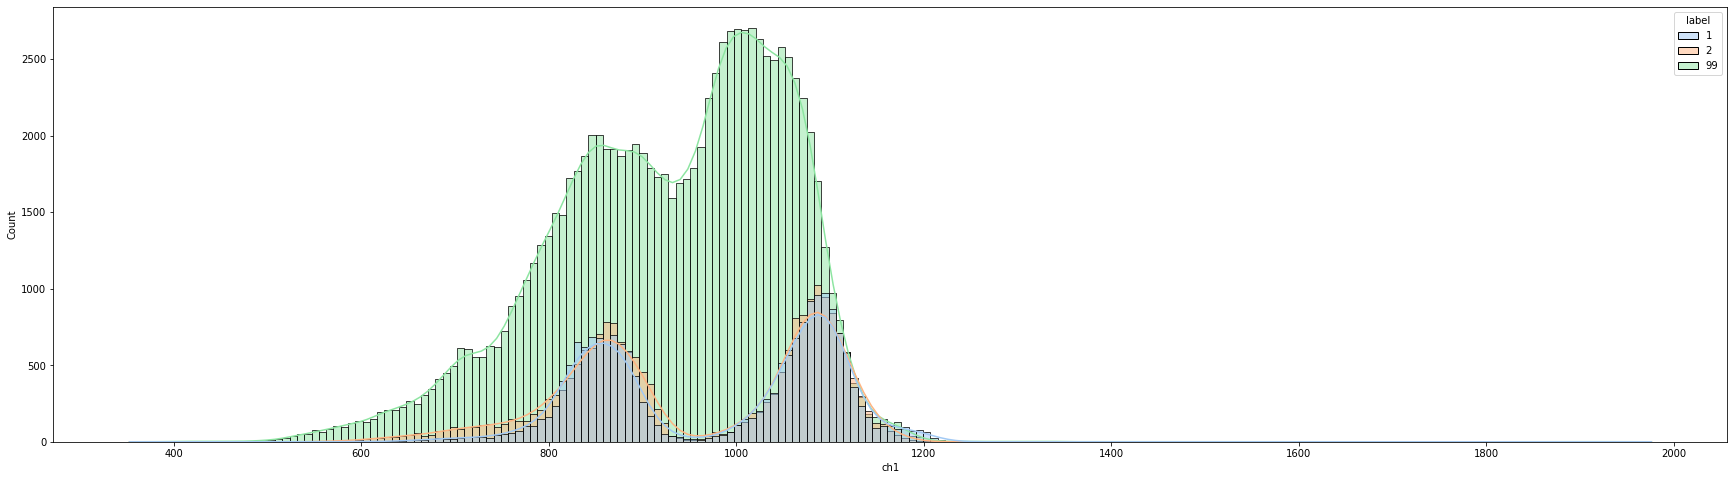

In [ ]:
plt.figure(figsize=(30, 8))

fig = sns.histplot(df_HA1_ch1, x= 'ch1', hue= 'label',kde= True, palette= 'pastel')
plt.show()

Volviendo con el paciente que estudiamos al principio (el AA1) realizamos histogramas separados para cada estado y también un gráfico de densidad como otra forma de visualizar la distibición de los voltajes

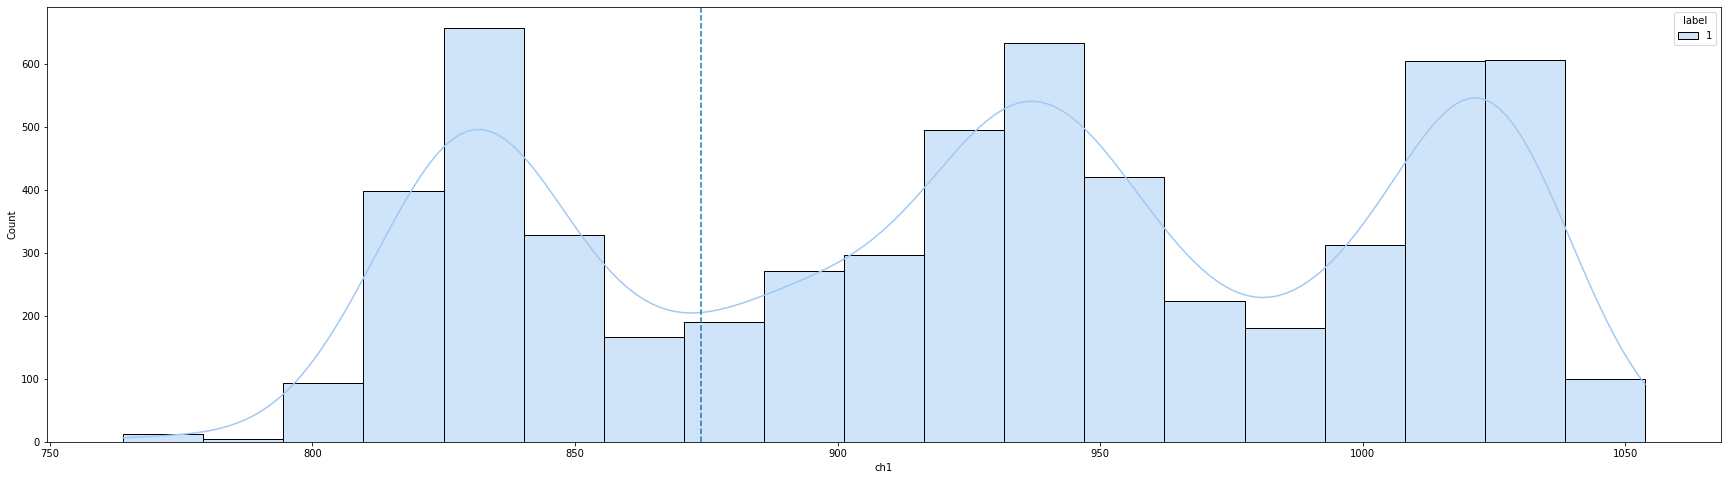

In [ ]:
plt.figure(figsize=(30, 8))

fig = sns.histplot(df_AA1_ch1_1_short, x= 'ch1', hue= 'label',kde= True, palette= 'pastel')
fig.axvline(df_medias.ch1.mean(), linestyle='--')

plt.show()

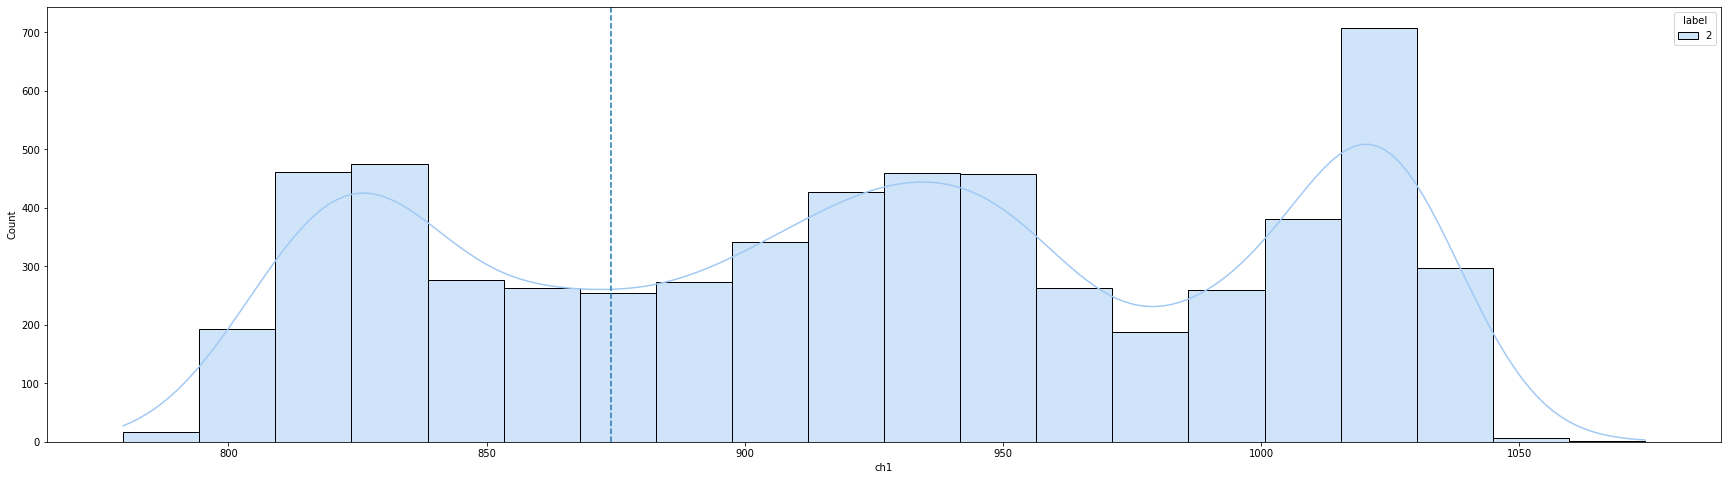

In [ ]:
plt.figure(figsize=(30, 8))

fig = sns.histplot(df_AA1_ch1_2_short, x= 'ch1', hue= 'label',kde= True, palette= 'pastel')
fig.axvline(df_medias.ch1.mean(), linestyle='--')
plt.show()

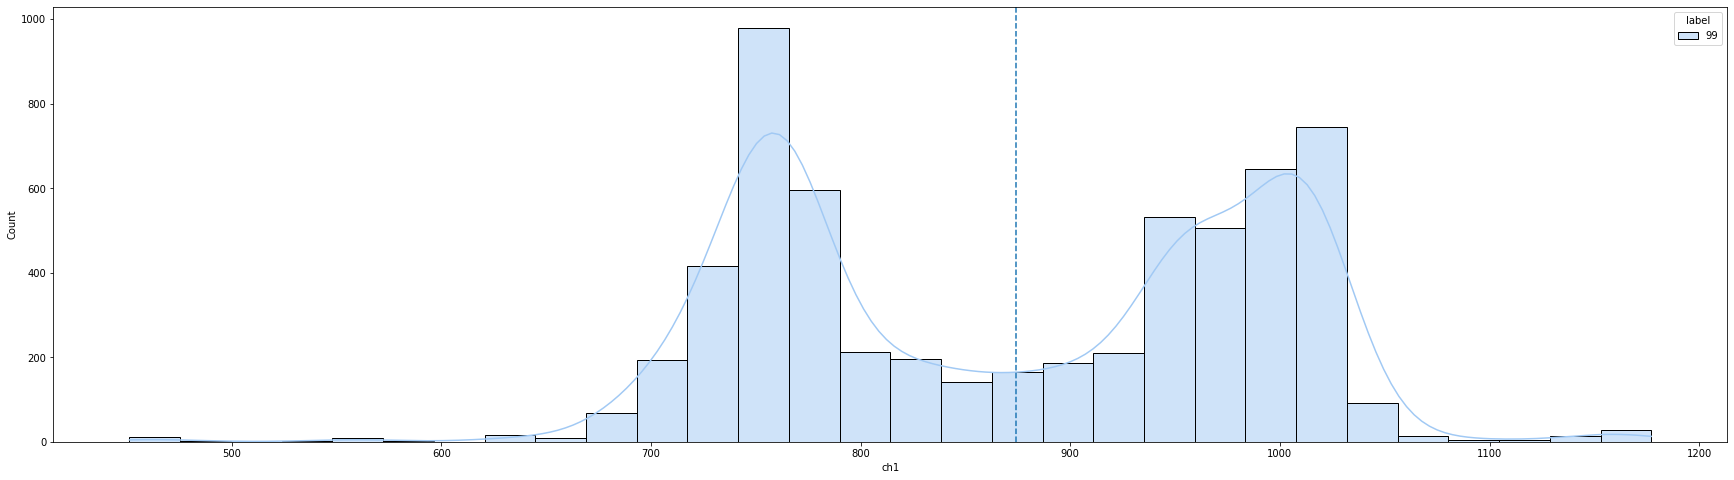

In [ ]:
plt.figure(figsize=(30, 8))

fig = sns.histplot(df_AA1_ch1_99_short, x= 'ch1', hue= 'label',kde= True, palette= 'pastel')
fig.axvline(df_medias.ch1.mean(), linestyle='--')
plt.show()

Otra forma de realizar un histograma con los tres valores de estados (label) para el paciente AA1

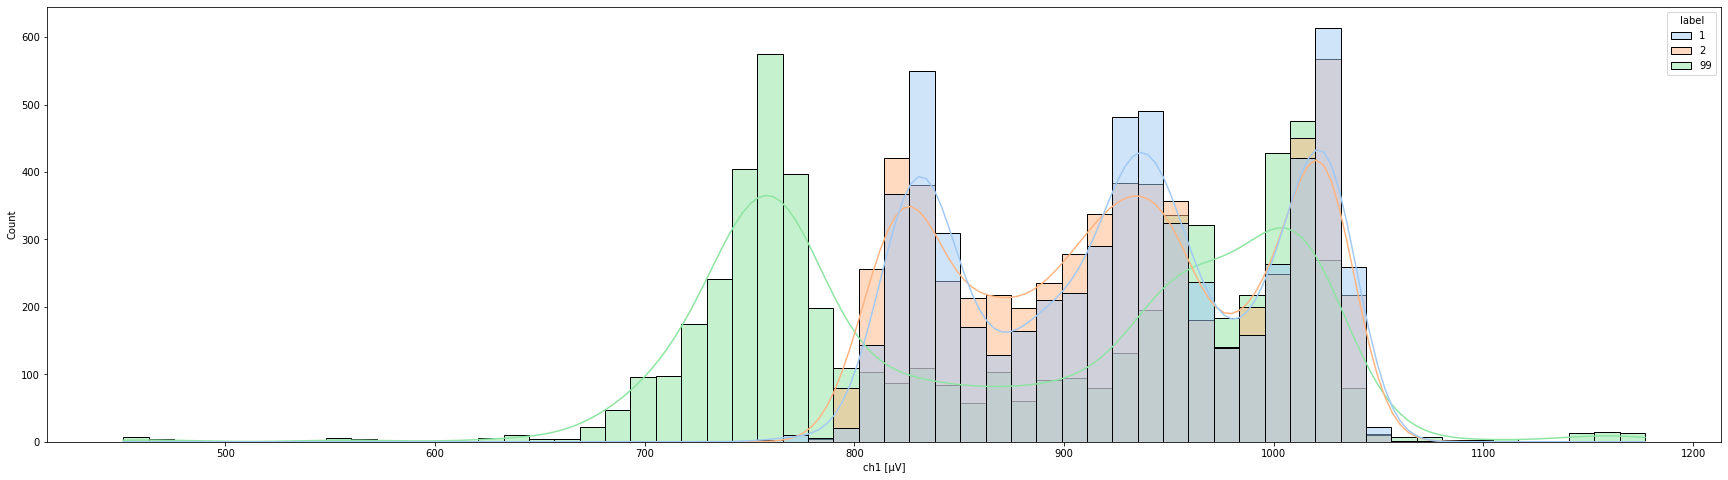

In [ ]:
plt.figure(figsize=(30, 8))

fig = sns.histplot(df_short_total, x= 'ch1', hue= 'label',kde= True, palette= 'pastel')
plt. xlabel ('ch1 [µV]')
plt.show()

Gráfico de densidad

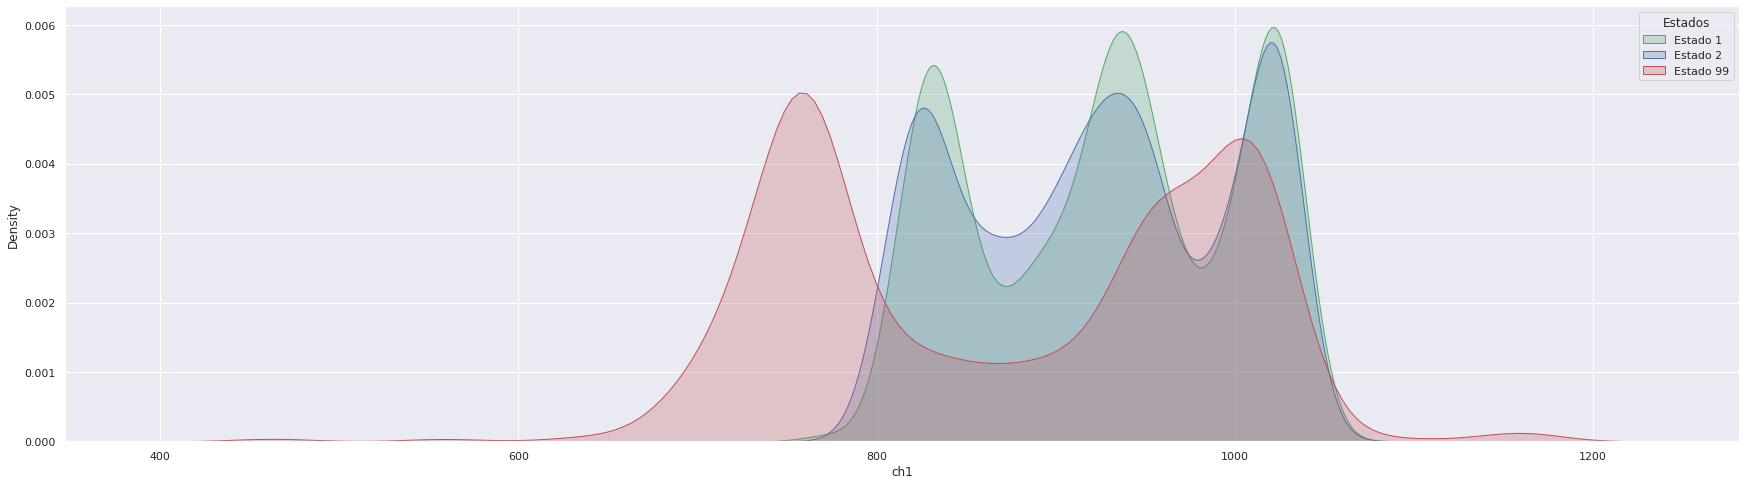

In [ ]:
plt.figure(figsize=(30, 8))
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

 
# plotting both distibutions on the same figure
fig = sns.kdeplot(df_AA1_ch1_1_short['ch1'], shade=True, color="g")
fig = sns.kdeplot(df_AA1_ch1_2_short['ch1'], shade=True, color="b")
fig = sns.kdeplot(df_AA1_ch1_99_short['ch1'], shade=True, color="r")
fig.legend(title='Estados', labels=estados)
plt.show()

Test no paramétrico de Kolmogorov-Smirnov 

In [ ]:
import scipy.stats as stats
import numpy as np
def kstest(dataset):
 media = np.mean(dataset)
 std = np.std(dataset)
 ks_stat, ks_p_value = stats.kstest(dataset, cdf='norm', args=(media,std), N= dataset.count())
 return print ('Los estadísticos según el test de kolmogorov-smirnov para el conjunto de datos son:' ,ks_stat, ks_p_value )

In [ ]:
data_1 = [df_AA1_ch1_1_short['ch1'], df_AA1_ch1_2_short['ch1'], df_AA1_ch1_99_short['ch1']]
for data in data_1:
  kstest(data)


Los estadísticos según el test de kolmogorov-smirnov para el conjunto de datos son: 0.0938739209756628 1.817423487125089e-46
Los estadísticos según el test de kolmogorov-smirnov para el conjunto de datos son: 0.08334994661732054 1.038602226808831e-36
Los estadísticos según el test de kolmogorov-smirnov para el conjunto de datos son: 0.14950981731985363 1.5196592902492923e-117


### b) Realice un resumen estadístico de los valores de voltaje en el intervalo de tiempo considerado. ¿Qué estimador de posición central usaría para describir los valores? ¿Y de dispersión?


In [ ]:
df_AA1_ch1_1_short.describe()

,ch1,time,label
count,6000.000000,6000.000000,6000.0
mean,928.546978,130.022540,1.0
std,72.780084,29.759003,0.0
min,763.970000,90.710000,1.0
25%,855.612500,98.208750,1.0
50%,933.450000,129.387500,1.0
75%,999.372500,166.646250,1.0
max,1053.750000,174.145000,1.0


In [ ]:
df_AA1_ch1_2_short.describe()

,ch1,time,label
count,6000.000000,6000.000000,6000.0
mean,924.508878,113.468873,2.0
std,73.487398,28.755372,0.0
min,779.610000,74.945000,2.0
25%,858.020000,82.443750,2.0
50%,927.570000,113.642500,2.0
75%,995.330000,148.386250,2.0
max,1074.310000,155.885000,2.0


In [ ]:
df_AA1_ch1_99_short.describe()

,ch1,time,label
count,6000.000000,6000.000000,6000.0
mean,873.997347,14.997500,99.0
std,117.612500,8.660976,0.0
min,451.280000,0.000000,99.0
25%,761.547500,7.498750,99.0
50%,883.350000,14.997500,99.0
75%,986.917500,22.496250,99.0
max,1177.090000,29.995000,99.0


### c) En adición a los datos dañados encontrados en la parte I, ¿Encuentra outliers a este nivel de análisis? ¿Estos outliers deberían ser tratados de forma diferencial? ¿De qué manera?


Text(0.5, 0, 'ch1 [µV]')

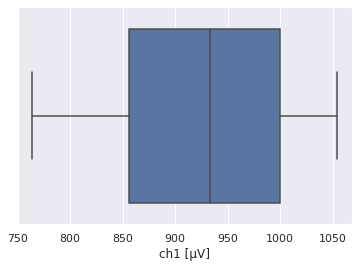

In [ ]:
import seaborn as sns
seaborn.boxplot(data=df_AA1_ch1_1_short , x= df_AA1_ch1_1_short['ch1'])
plt. xlabel ('ch1 [µV]')

Text(0.5, 0, 'ch1 [µV]')

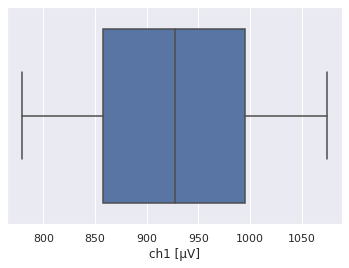

In [ ]:
seaborn.boxplot(data= df_AA1_ch1_2_short, x= df_AA1_ch1_2_short['ch1'])
plt. xlabel ('ch1 [µV]')

Text(0.5, 0, 'ch1 [µV]')

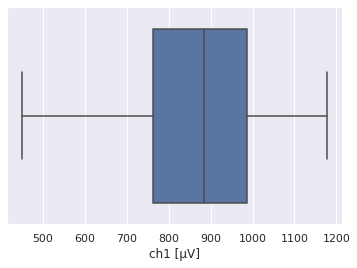

In [ ]:
seaborn.boxplot(data= df_AA1_ch1_99_short, x= df_AA1_ch1_99_short['ch1'])
plt. xlabel ('ch1 [µV]')

### d) ¿Existe una diferencia estadísticamente significativa para considerar que los estimadores de posición central son diferentes entre los estados? Use un test de hipótesis para probarlo al menos entre dos estados.

Realizamos un t-test de student para comparar las medias de los datos de los 3 estados del paciente AA1.
Las hipótesis planteadas son las siguientes:
H0: the means of the samples are equal.
H1: the means of the samples are unequal.
Definimos que dos muestras son estadisticamente diferentes si su p-valor es menor a 0,001

In [ ]:
# Example of the Student's t-test
import scipy.stats as stats
stats.ttest_ind (df_AA1_ch1_1_short['ch1'],
                 df_AA1_ch1_2_short['ch1'])
              

Ttest_indResult(statistic=3.024230086927614, pvalue=0.002497938989936647)

In [ ]:
stats.ttest_ind (df_AA1_ch1_1_short['ch1'],
                 df_AA1_ch1_99_short['ch1'])

Ttest_indResult(statistic=30.550198782511902, pvalue=1.829466998169589e-197)

In [ ]:
stats.ttest_ind (df_AA1_ch1_2_short['ch1'],
                 df_AA1_ch1_99_short['ch1'])

Ttest_indResult(statistic=28.212498127472703, pvalue=1.3153702295850544e-169)

### e) Resuma las principales conclusiones de este nivel de análisis.

## B) Nivel Paciente - un canal: Seleccione los datos correspondientes a un paciente y un canal de adquisición y para ese caso estudie los siguientes elementos:





### a) Considere el conjunto completo de valores de voltaje correspondientes a cada uno de los estados a lo largo de todo el registro y repita los elementos del apartado II-A).

In [ ]:
df_AA1_ch1 = df_AA1[['ch1','time','label']]
df_AA1_ch1

,ch1,time,label
0,994.82,0.000,99
1,836.23,0.005,99
2,650.03,0.010,99
3,848.86,0.015,99
4,980.78,0.020,99
...,...,...,...
138164,1034.31,690.820,99
138165,952.31,690.825,99
138166,891.24,690.830,99
138167,984.00,690.835,99


Elegimos el hitograma como criterio gráfico para evaluar distribución normal

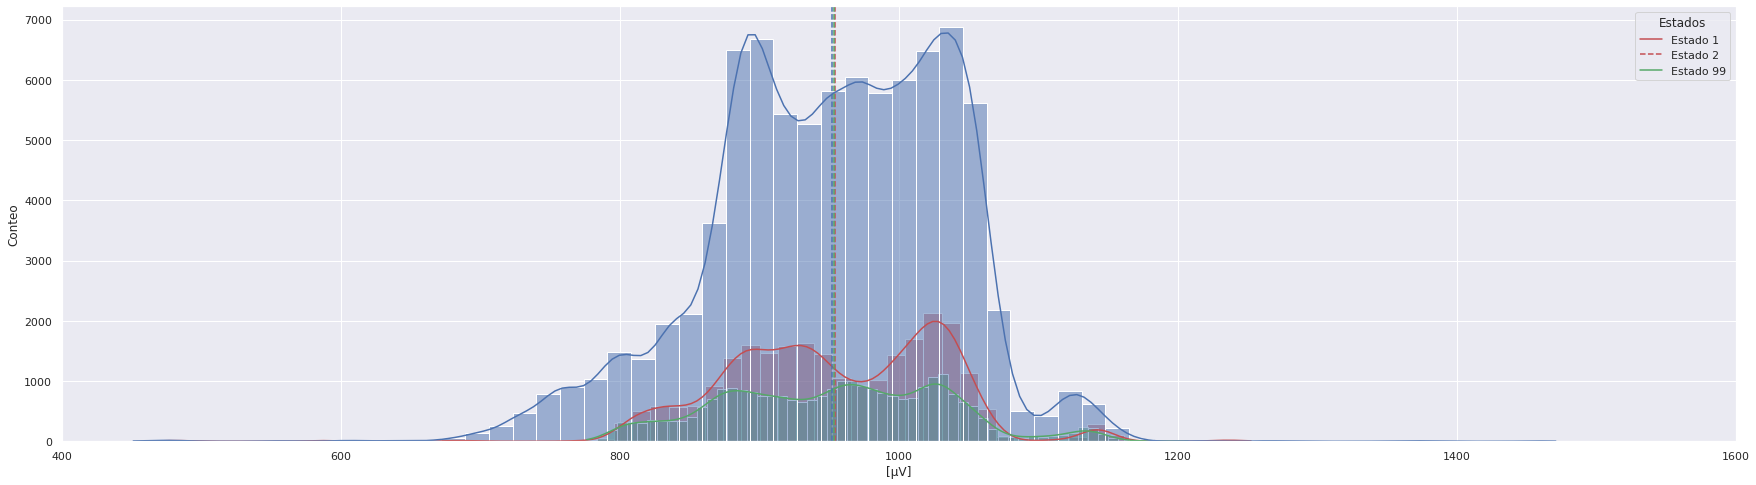

In [ ]:
plt.figure(figsize=(30, 8))

estados = ['Estado 1', 'Estado 2','Estado 99']
df_AA1_ch1_1 = df_AA1_ch1[df_AA1_ch1['label'] == 1 ]
df_AA1_ch1_2 = df_AA1_ch1[df_AA1_ch1['label'] == 2 ]
df_AA1_ch1_99 = df_AA1_ch1[df_AA1_ch1['label'] == 99 ]

df_plot_hist = [(df_AA1_ch1_1, 'AA-1'),(df_AA1_ch1_2, 'AA-2'),(df_AA1_ch1_99, 'AA-99')]

color_list = ('r','g','b')

for i in range(3):
  fig = seaborn.histplot(df_plot_hist[i][0], x="ch1", bins = 60, color=color_list[i], kde = True)
  df_medias = df_plot_hist[i][0]
  fig.axvline(df_medias.ch1.mean(), color=color_list[i], linestyle='--')

fig.set(xlim=(400, 1600))
fig.set_ylabel("Conteo")
fig.set_xlabel("[µV]")
fig.legend(title='Estados', labels=estados)


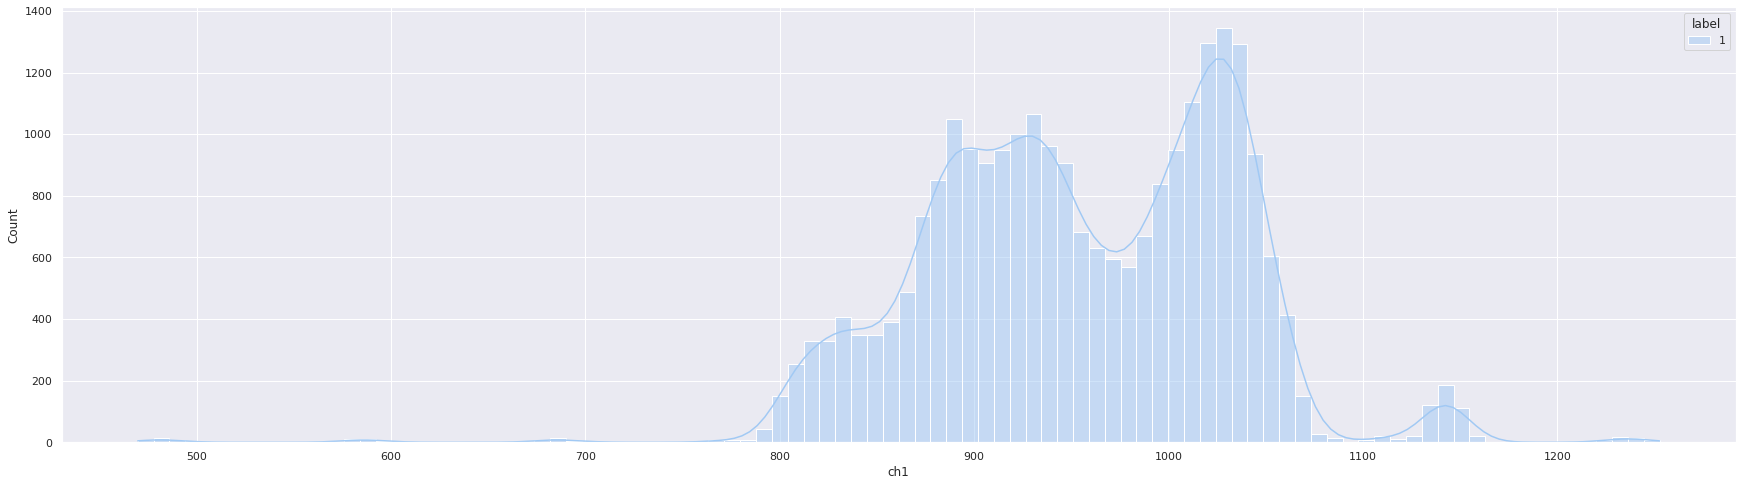

In [ ]:
plt.figure(figsize=(30, 8))

fig = sns.histplot(df_AA1_ch1_1, x= 'ch1', hue= 'label',kde= True, palette= 'pastel')
plt.show()

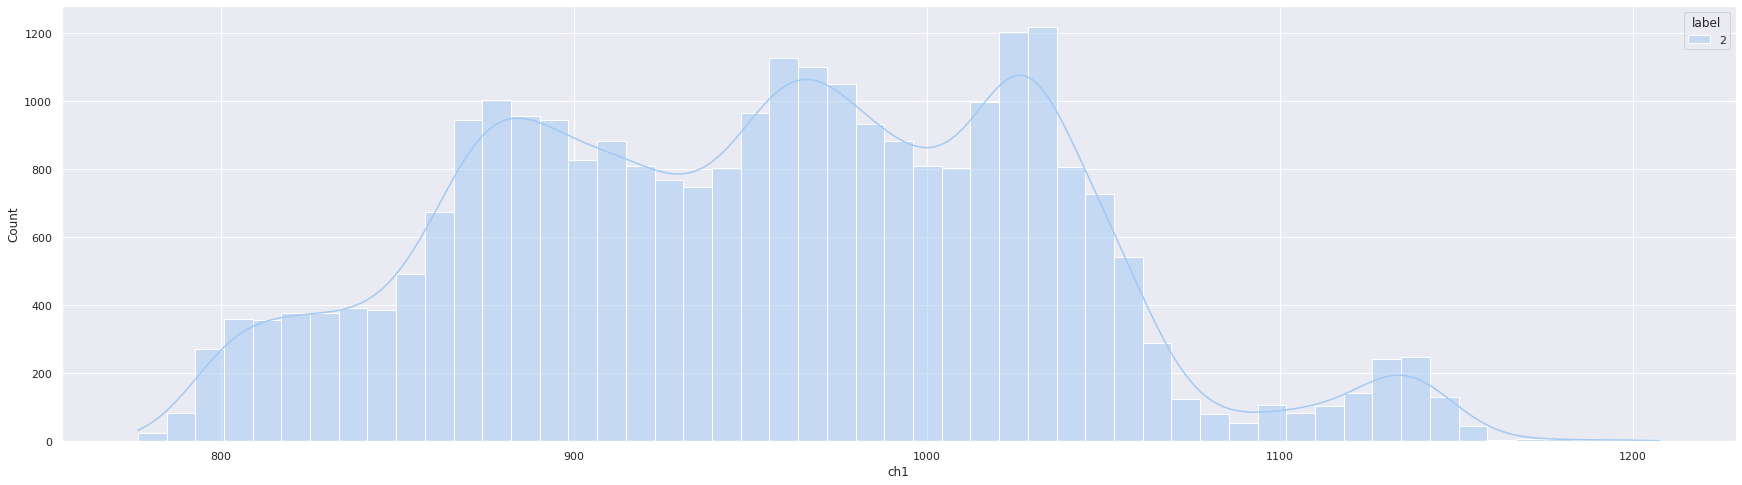

In [ ]:
plt.figure(figsize=(30, 8))

fig = sns.histplot(df_AA1_ch1_2, x= 'ch1', hue= 'label',kde= True, palette= 'pastel')
plt.show()

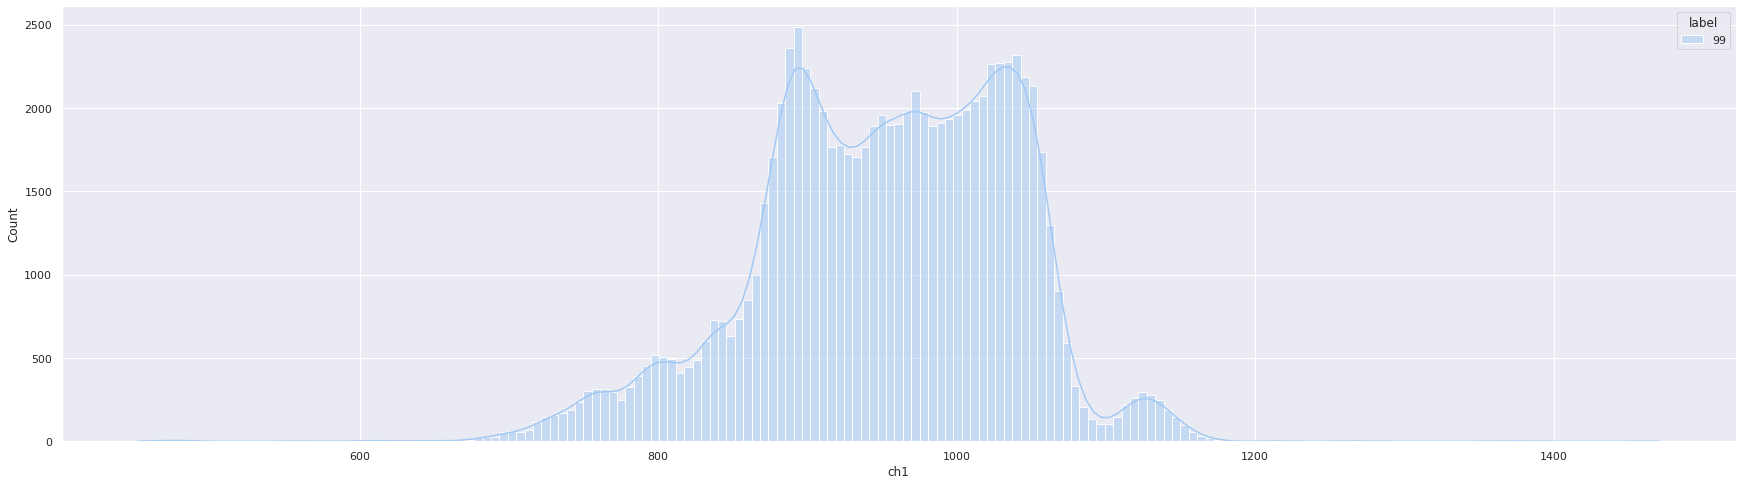

In [ ]:
plt.figure(figsize=(30, 8))

fig = sns.histplot(df_AA1_ch1_99, x= 'ch1', hue= 'label',kde= True, palette= 'pastel')
plt.show()

In [ ]:
df_AA1_ch1_total = df_AA1_ch1_1
df_AA1_ch1_total = df_AA1_ch1_total.append(df_AA1_ch1_2, ignore_index=True)
df_AA1_ch1_total = df_AA1_ch1_total.append(df_AA1_ch1_99, ignore_index= True)
print (df_AA1_ch1_total)

            ch1     time  label
0        994.21   90.710      1
1        856.17   90.715      1
2        864.23   90.720      1
3       1018.17   90.725      1
4        969.74   90.730      1
...         ...      ...    ...
138164  1034.31  690.820     99
138165   952.31  690.825     99
138166   891.24  690.830     99
138167   984.00  690.835     99
138168  1026.24  690.840     99

[138169 rows x 3 columns]


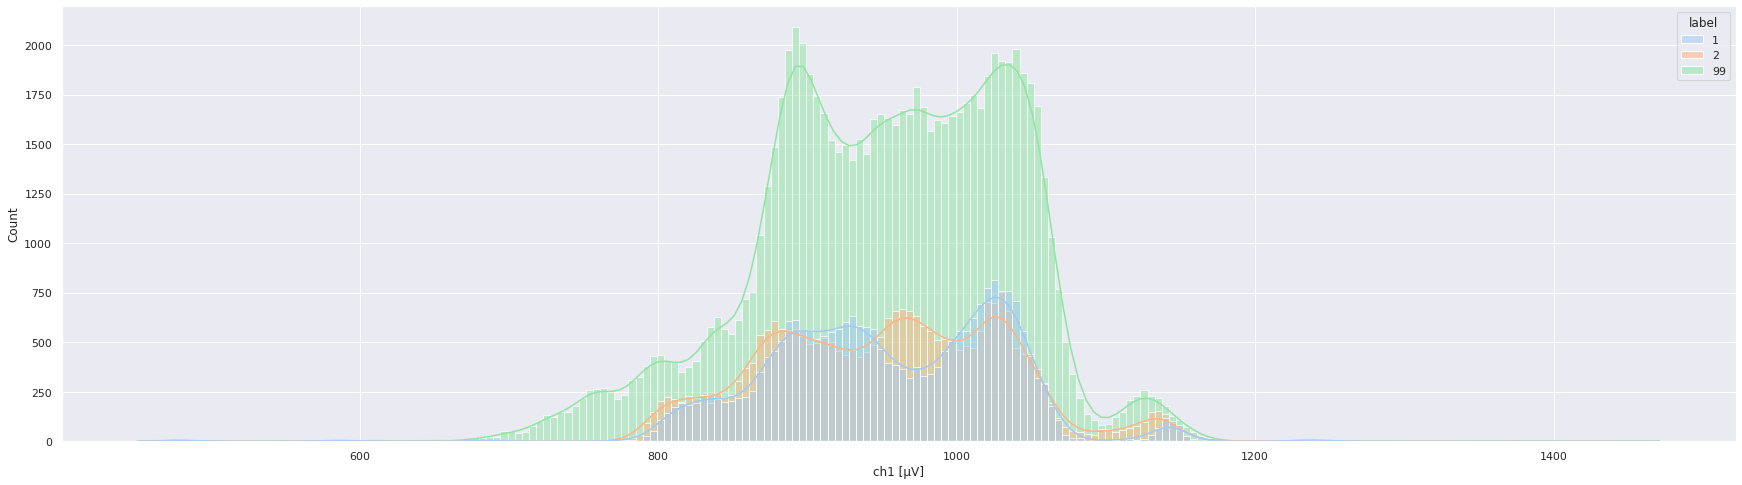

In [ ]:
plt.figure(figsize=(30, 8))

fig = sns.histplot(df_AA1_ch1_total, x= 'ch1', hue= 'label',kde= True, palette= 'pastel')
plt. xlabel ('ch1 [µV]')
plt.show()

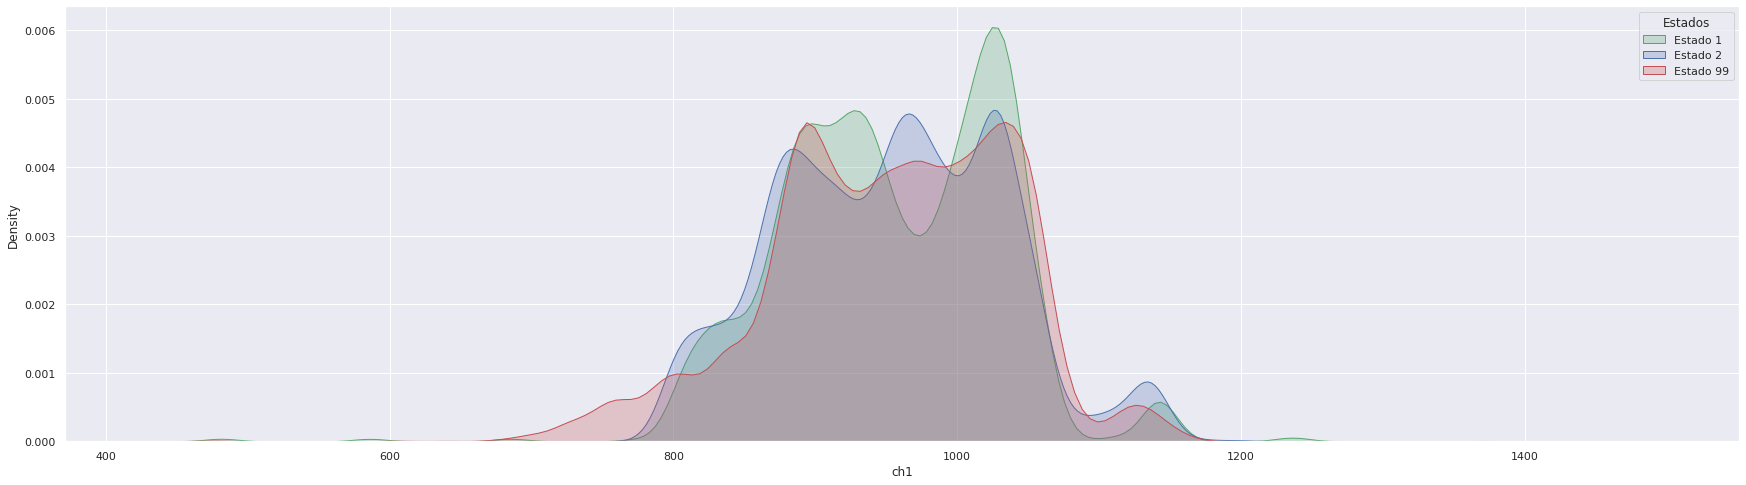

In [ ]:
plt.figure(figsize=(30, 8))
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

 
# plotting both distibutions on the same figure
fig = sns.kdeplot(df_AA1_ch1_1['ch1'], shade=True, color="g")
fig = sns.kdeplot(df_AA1_ch1_2['ch1'], shade=True, color="b")
fig = sns.kdeplot(df_AA1_ch1_99['ch1'], shade=True, color="r")
fig.legend(title='Estados', labels=estados)
plt.show()

Realizamos el test de kolmogorov-smirnov para determinar si los datos graficados provienen de una distribución normal

In [ ]:
data_set_list = [df_AA1_ch1_1['ch1'], df_AA1_ch1_2['ch1'], df_AA1_ch1_99['ch1']]
for data in data_set_list:
  kstest (data)

Los estadísticos según el test de kolmogorov-smirnov para el conjunto de datos son: 0.06592516356030198 1.0542109040048149e-95
Los estadísticos según el test de kolmogorov-smirnov para el conjunto de datos son: 0.03892888953542273 2.0037299448272755e-36
Los estadísticos según el test de kolmogorov-smirnov para el conjunto de datos son: 0.04250755058493105 7.022657776100944e-135


In [ ]:
data_norm = np.random.normal(np.mean(df_AA1_ch1_1['ch1']), np.std(df_AA1_ch1_1['ch1']),df_AA1_ch1_1['ch1'].count())

In [ ]:
values, base = np.histogram(df_AA1_ch1_1['ch1'])
values_norm, base_norm = np.histogram(data_norm)

In [ ]:
cumulative = np.cumsum(values)
cumulative_norm = np.cumsum(values_norm)

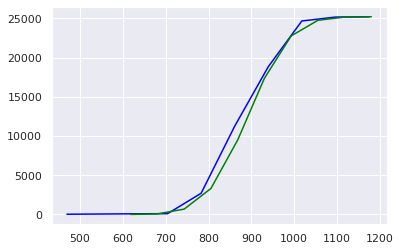

In [ ]:
plt.plot(base[:-1], cumulative, c='blue')
plt.plot(base_norm[:-1], cumulative_norm, c='green')
plt.show()


In [ ]:
from scipy.stats import kstest
result = (kstest(df_AA1_ch1_1['ch1'], cdf='norm'))
print(f"K-S statistic: {result[0]}")
print(f"p-value: {result[1]}")

K-S statistic: 1.0
p-value: 0.0


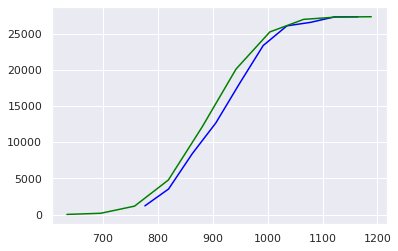

In [ ]:
data_norm = np.random.normal(np.mean(df_AA1_ch1_2['ch1']), np.std(df_AA1_ch1_2['ch1']),df_AA1_ch1_2['ch1'].count())
values, base = np.histogram(df_AA1_ch1_2['ch1'])
values_norm, base_norm = np.histogram(data_norm)
cumulative = np.cumsum(values)
cumulative_norm = np.cumsum(values_norm)
plt.plot(base[:-1], cumulative, c='blue')
plt.plot(base_norm[:-1], cumulative_norm, c='green')
plt.show()

In [ ]:
result = (kstest(df_AA1_ch1_2['ch1'], cdf='norm'))
print(f"K-S statistic: {result[0]}")
print(f"p-value: {result[1]}")

K-S statistic: 1.0
p-value: 0.0


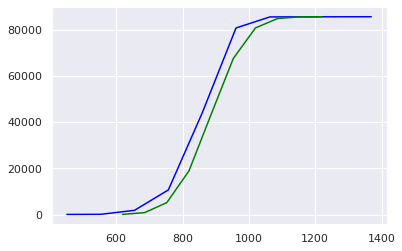

In [ ]:
data_norm = np.random.normal(np.mean(df_AA1_ch1_99['ch1']), np.std(df_AA1_ch1_99['ch1']),df_AA1_ch1_99['ch1'].count())
values, base = np.histogram(df_AA1_ch1_99['ch1'])
values_norm, base_norm = np.histogram(data_norm)
cumulative = np.cumsum(values)
cumulative_norm = np.cumsum(values_norm)
plt.plot(base[:-1], cumulative, c='blue')
plt.plot(base_norm[:-1], cumulative_norm, c='green')
plt.show()

In [ ]:
result = (kstest(df_AA1_ch1_99['ch1'], cdf='norm'))
print(f"K-S statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(result)

K-S statistic: 1.0
p-value: 0.0
KstestResult(statistic=1.0, pvalue=0.0)


In [ ]:
df_AA1_ch1_1.describe()

,ch1,time,label
count,25210.000000,25210.000000,25210.0
mean,954.391747,363.986869,1.0
std,77.301691,196.409915,0.0
min,469.690000,90.710000,1.0
25%,897.642500,193.741250,1.0
50%,951.330000,268.972500,1.0
75%,1018.260000,520.323750,1.0
max,1252.590000,674.910000,1.0


In [ ]:
df_AA1_ch1_2.describe()

,ch1,time,label
count,27331.000000,27331.000000,27331.0
mean,953.729099,363.502762,2.0
std,78.625753,209.907422,0.0
min,776.390000,74.945000,2.0
25%,891.490000,182.582500,2.0
50%,956.880000,278.285000,2.0
75%,1015.480000,542.142500,2.0
max,1207.520000,689.495000,2.0


In [ ]:
df_AA1_ch1_99.describe()

,ch1,time,label
count,85628.000000,85628.000000,85628.0
mean,951.981044,334.181962,99.0
std,85.349934,196.021652,0.0
min,451.280000,0.000000,99.0
25%,894.620000,159.593750,99.0
50%,957.720000,350.687500,99.0
75%,1018.890000,489.236250,99.0
max,1471.020000,690.840000,99.0


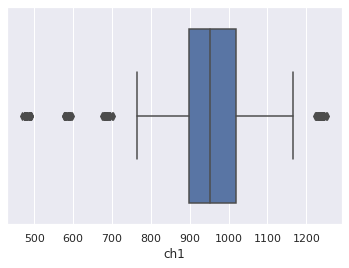

In [ ]:
seaborn.boxplot(data= df_AA1_ch1_1, x= df_AA1_ch1_1 ['ch1'])

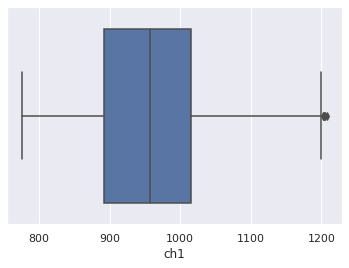

In [ ]:
seaborn.boxplot(data= df_AA1_ch1_2, x= df_AA1_ch1_2 ['ch1'])

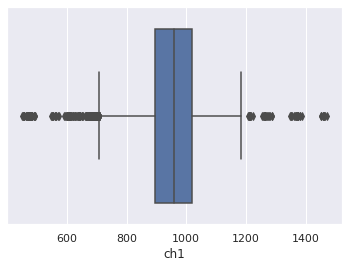

In [ ]:
seaborn.boxplot(data= df_AA1_ch1_99, x= df_AA1_ch1_99 ['ch1'])

In [ ]:
import scipy.stats as stats
stats.ttest_ind (df_AA1_ch1_1['ch1'],
                 df_AA1_ch1_2['ch1'])
              

Ttest_indResult(statistic=0.9729509715440818, pvalue=0.3305821493762561)

In [ ]:
import scipy.stats as stats
stats.ttest_ind (df_AA1_ch1_1['ch1'],
                 df_AA1_ch1_99['ch1'])
              

Ttest_indResult(statistic=4.024874946717955, pvalue=5.704343319624697e-05)

In [ ]:
import scipy.stats as stats
stats.ttest_ind (df_AA1_ch1_2['ch1'],
                 df_AA1_ch1_99['ch1'])
              

Ttest_indResult(statistic=3.003508558407704, pvalue=0.0026694447237093984)

### b) Ahora que dispone de más datos, ¿son variables independientes el estado registrado de la señal y su voltaje? Use herramientas cuantitativas y cualitativas para justificar su respuesta.

In [ ]:
df_AA1_ch1
print(df_AA1_ch1)

            ch1     time  label
0        994.82    0.000     99
1        836.23    0.005     99
2        650.03    0.010     99
3        848.86    0.015     99
4        980.78    0.020     99
...         ...      ...    ...
138164  1034.31  690.820     99
138165   952.31  690.825     99
138166   891.24  690.830     99
138167   984.00  690.835     99
138168  1026.24  690.840     99

[138169 rows x 3 columns]


In [ ]:
data_filtrado = df_AA1_ch1[df_AA1_ch1 ['label']!= 99]
print(data_filtrado)

            ch1     time  label
14989    814.71   74.945      2
14990    969.21   74.950      2
14991   1025.39   74.955      2
14992    910.16   74.960      2
14993    824.23   74.965      2
...         ...      ...    ...
137895   965.17  689.475      2
137896  1036.79  689.480      2
137897   970.61  689.485      2
137898   904.75  689.490      2
137899   982.83  689.495      2

[52541 rows x 3 columns]


Text(0.5, 1.0, 'Correlación entre estados y canal 1 en el paciente AA sesión 1 ')

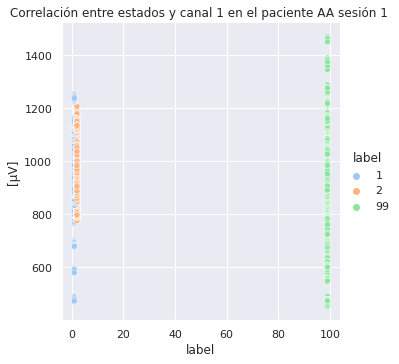

In [ ]:
import matplotlib.pyplot as plt
sns.relplot(data= df_AA1_ch1, x="label", y="ch1", hue="label",palette= 'pastel' )
plt. ylabel ('[µV]')
plt. title ('Correlación entre estados y canal 1 en el paciente AA sesión 1 ')



Text(0.5, 1.0, 'Correlación entre estados y canal 1 en el paciente AA sesión 1 ')

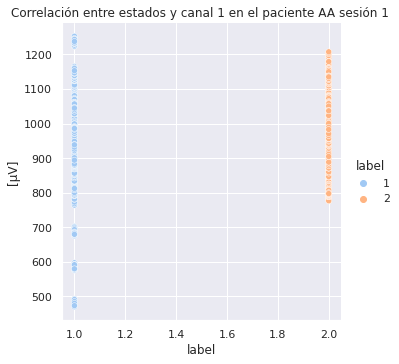

In [ ]:
import matplotlib.pyplot as plt
sns.relplot(data= data_filtrado, x="label", y="ch1", hue="label",palette= 'pastel' )
plt. ylabel ('[µV]')
plt. title ('Correlación entre estados y canal 1 en el paciente AA sesión 1 ')

Text(0.5, 1.0, 'Correlación entre los estados 1 y 2 y el voltaje medio de cada canal para todos los pacientes')

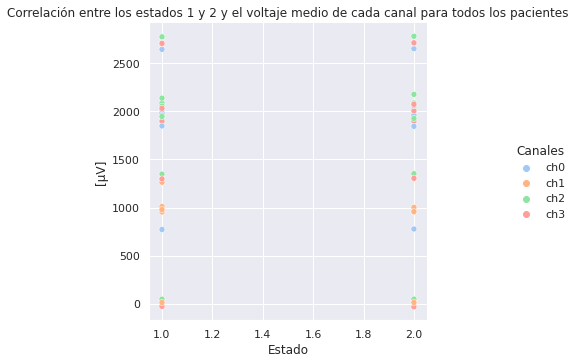

In [ ]:
dataframes = [df_AA0 ,df_AA1, df_AA2, df_HA1, df_JA1, df_JA2, df_MA1]
chanels = ['ch0', 'ch1', 'ch2', 'ch3']
estados = [1, 2]#, 99]
VpE = []
for df in dataframes:
  for ch in chanels:
    for es in estados:
      VpE.append( [df[df.label==es][ch].mean() ,es,ch] )
VpE = pd.DataFrame(VpE)
VpE.columns = ['Votaje medio [µV]', 'Estado', 'Canales']
sns.relplot(data= VpE, x="Estado", y="Votaje medio [µV]", hue="Canales",palette= 'pastel' )
plt. ylabel ('[µV]')
plt. title ('Correlación entre los estados 1 y 2 y el voltaje medio de cada canal para todos los pacientes')

### c) Para cada uno de los estados, los valores de voltaje a lo largo del tiempo, ¿varían con alguna tendencia?

### d) Resuma las principales conclusiones de este nivel de análisis.

##C)Nivel Paciente - multicanal: Seleccione los datos correspondientes a un paciente y para ese caso estudie los siguientes elementos:


Paciente seleccionado = AA sesión 1

In [ ]:
df_AA1

,ch0,ch1,ch2,ch3,label,time,Name
0,2081.61,994.82,2229.93,1975.38,99,0.000,AA1
1,1926.57,836.23,2065.95,1912.34,99,0.005,AA1
2,1744.17,650.03,1852.65,1883.84,99,0.010,AA1
3,1937.29,848.86,2050.07,1970.17,99,0.015,AA1
4,2079.86,980.78,2222.84,1981.65,99,0.020,AA1
...,...,...,...,...,...,...,...
138164,1854.27,1034.31,2152.96,1811.63,99,690.820,AA1
138165,1791.11,952.31,2071.41,1781.04,99,690.825,AA1
138166,1751.95,891.24,1981.05,1860.84,99,690.830,AA1
138167,1832.42,984.00,2070.59,1905.69,99,690.835,AA1


###a) Las señales de voltaje en función del tiempo para cada canal, ¿son variables independientes entre sí? Use herramientas cuantitativas y cualitativas para justificar su respuesta. (Ejemplo, matriz de correlación)

In [ ]:
df_AA1.corr()

,ch0,ch1,ch2,ch3,label,time
ch0,1.000000,0.587315,0.808805,0.375864,0.024025,-0.614953
ch1,0.587315,1.000000,0.903763,-0.203183,-0.012153,0.260103
ch2,0.808805,0.903763,1.000000,-0.138677,0.003034,-0.097328
ch3,0.375864,-0.203183,-0.138677,1.000000,0.049591,-0.611170
label,0.024025,-0.012153,0.003034,0.049591,1.000000,-0.071941
time,-0.614953,0.260103,-0.097328,-0.611170,-0.071941,1.000000


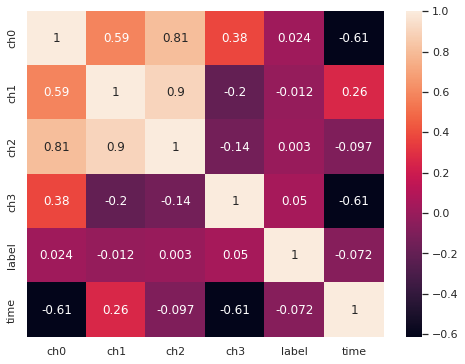

In [ ]:
corr_df = df_AA1.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

###b) Tomando los puntos que considere relevantes del apartado II-B) para cada canal y considerando la respuesta anterior. ¿Considera relevante trabajar con todos los canales disponibles o podría quedarse con un subconjunto? Si elige el subconjunto, ¿qué canales elegiría y por qué?

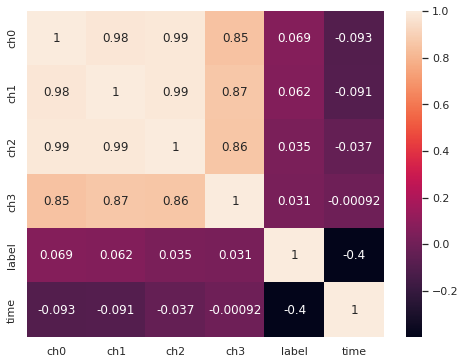

In [ ]:
corr_df = df_AA0.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

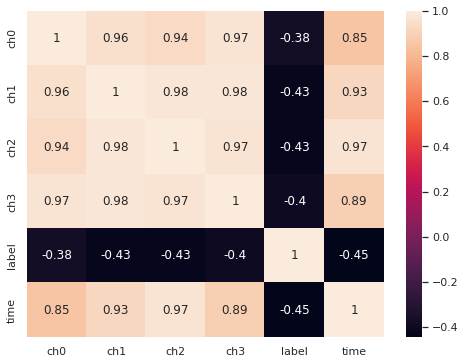

In [ ]:
corr_df = df_AA2.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

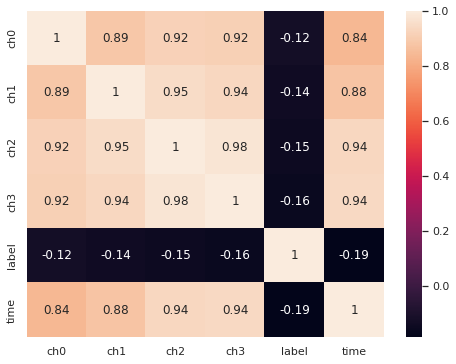

In [ ]:
corr_df = df_HA1.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

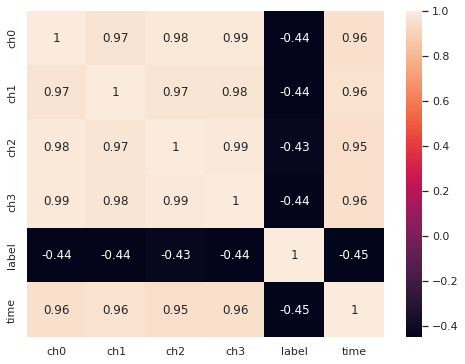

In [ ]:
corr_df = df_JA1.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

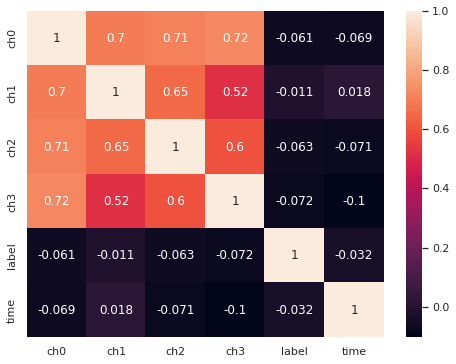

In [ ]:
corr_df = df_JA2.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

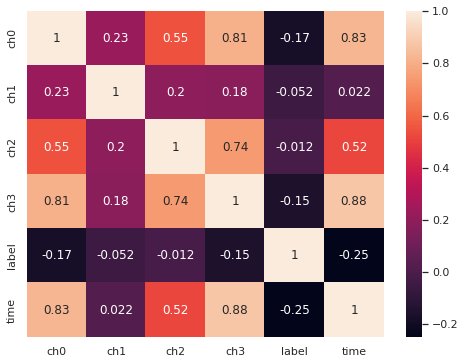

In [ ]:
corr_df = df_MA1.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

#D) Nivel Multi-Paciente

###a) A partir de las conclusiones extraídas de los niveles de análisis anteriores decida cuáles son los aspectos más importantes a analizar de los registros de un paciente y compárelos entre pacientes. ¿Encuentra diferencias significativas? ¿Qué variables pueden identificar esas diferencias? 
###A modo de ejemplo: los valores de voltaje medios para cada estado de un paciente, ¿difieren significativamente entre pacientes?

In [ ]:
df_AA1_stat_1 = df_AA1[df_AA1.label==1]['ch1']
print(df_AA1_stat)

18142      994.21
18143      856.17
18144      864.23
18145     1018.17
18146      969.74
           ...   
134978     983.29
134979     893.98
134980     938.35
134981    1044.65
134982     985.89
Name: ch1, Length: 25210, dtype: float64


In [ ]:
df_JA1_stat_1 = df_JA1[df_JA1.label==1]['ch1']
print(df_JA1_stat)

15628    2652.14
15629    2649.72
15630    2644.64
15631    2645.06
15632    2653.53
          ...   
52159    2738.95
52160    2739.76
52161    2732.25
52162    2728.81
52163    2738.26
Name: ch1, Length: 12630, dtype: float64


In [ ]:
import scipy.stats as stats
stats.ttest_ind (df_AA1_stat_1,
                 df_JA1_stat_1)
              

Ttest_indResult(statistic=-2452.719784415657, pvalue=0.0)

In [ ]:
df_AA1_stat_2 = df_AA1[df_AA1.label==2]['ch1']
df_JA1_stat_2 = df_JA1[df_JA1.label==2]['ch1']
stats.ttest_ind (df_AA1_stat_2,
                 df_JA1_stat_2)

Ttest_indResult(statistic=-2441.425640784631, pvalue=0.0)

In [ ]:
df_AA1_stat_99 = df_AA1[df_AA1.label==99]['ch1']
df_JA1_stat_99 = df_JA1[df_JA1.label==99]['ch1']
stats.ttest_ind (df_AA1_stat_99,
                 df_JA1_stat_99)

Ttest_indResult(statistic=-3384.779778662258, pvalue=0.0)

In [ ]:
df_HA1_stat_1 = df_HA1[df_HA1.label==1]['ch1']
stats.ttest_ind (df_AA1_stat_1,
                 df_HA1_stat_1)

Ttest_indResult(statistic=-24.534790726616343, pvalue=4.8361200439161636e-132)

In [ ]:
df_HA1_stat_2 = df_HA1[df_HA1.label==2]['ch1']
stats.ttest_ind (df_AA1_stat_2,
                 df_HA1_stat_2)

Ttest_indResult(statistic=-4.116062873692886, pvalue=3.86037655558061e-05)

In [ ]:
df_HA1_stat_99 = df_HA1[df_HA1.label==99]['ch1']
stats.ttest_ind (df_AA1_stat_99,
                 df_HA1_stat_99)

Ttest_indResult(statistic=44.85081655464578, pvalue=0.0)

In [ ]:
dataframes = [(df_AA0, 'AA0'), (df_AA1, 'AA1'), (df_AA2, 'AA2'), (df_HA1,'HA1'), (df_JA1, 'JA1'), (df_JA2, 'JA2'), (df_MA1, 'MA1')]
#estados[1,2,99]
for df, name in dataframes:
  print(name)
  print((df[df.label==1]['ch0'].mean(),df[df.label==2]['ch0'].mean(),df[df.label==99]['ch0'].mean()))
  print((df[df.label==1]['ch0'].std(),df[df.label==2]['ch0'].std(),df[df.label==99]['ch0'].std()))
print()

AA0
(39.70890262121418, 41.10755468007064, 47.36764357034796)
(47.49518000634093, 47.544714713544586, 49.40405958926675)
AA1
(1889.6383938913127, 1891.6605067505764, 1895.0060343579205)
(87.28254184849523, 89.70507337138186, 86.59962687709348)
AA2
(1847.0156607859706, 1843.1282403576356, 1781.9943466098687)
(57.75914763119172, 52.18837159975078, 82.99838291033056)
HA1
(1981.8877439797209, 1960.8198064577484, 1938.8386903446296)
(120.81024256163704, 123.58007918729459, 113.77212540418374)
JA1
(2642.2331409342833, 2649.544375545159, 2613.2796747117795)
(25.899233924872217, 24.19768759434165, 38.280497308897104)
JA2
(2014.9944615465988, 2060.553827307326, 1663.7515844422367)
(122.29104099907018, 121.62553416793031, 3837.5436203656136)
MA1
(771.9767680126682, 777.2742694226658, 762.8479126268193)
(24.31600833257242, 26.614271079960993, 35.47909965029052)



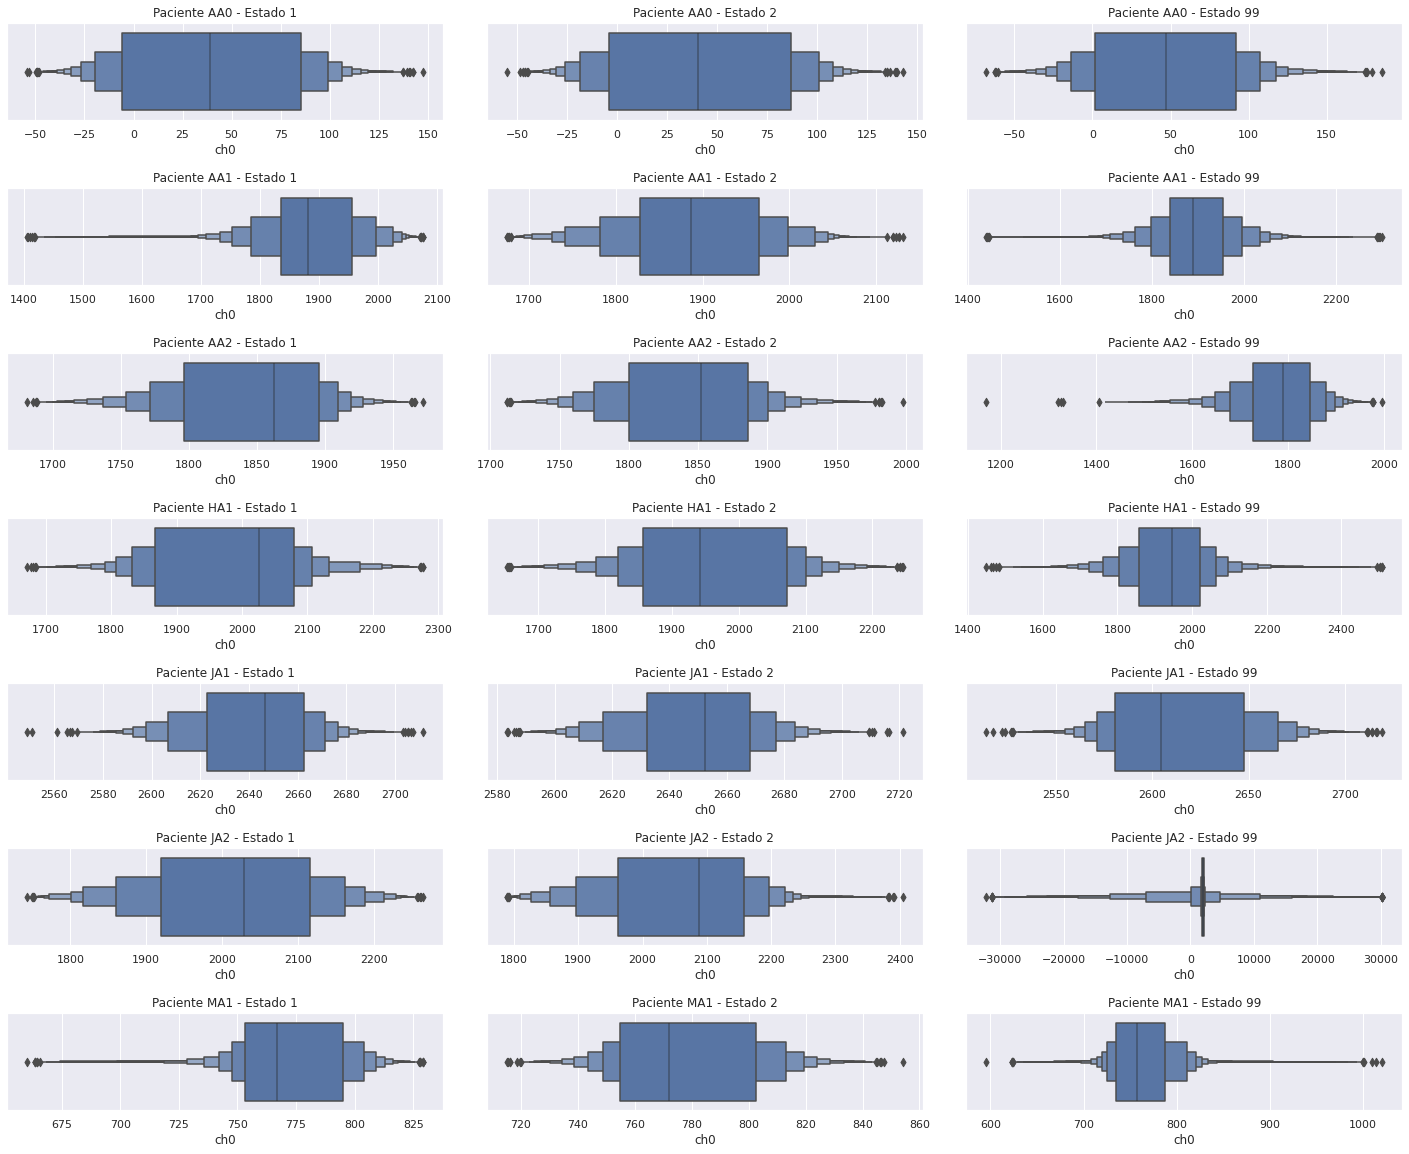

In [ ]:
def label_time(dataframe,label):
  result = dataframe[dataframe.label==label]
  result = result.drop(['time'], axis=1)
  result = result.copy()
  result = result.reset_index()
  result['time'] = result.index.values/200
  return result
dataframes = [(df_AA0, 'AA0'), (df_AA1, 'AA1'), (df_AA2, 'AA2'), (df_HA1,'HA1'), (df_JA1, 'JA1'), (df_JA2, 'JA2'), (df_MA1, 'MA1')]
fig, axes = plt.subplots(ncols=3,nrows=len(dataframes), figsize=(25, 20))
plt.subplots_adjust(wspace=0.1,
hspace=0.7)

for (i,(df,name)) in enumerate(dataframes):
  for j,estado in enumerate([1,2,99]):
    a = seaborn.boxenplot(data=label_time(df,estado), x="ch0",ax=axes[i][j])
    a.set_title(f"Paciente {name} - Estado {estado}")

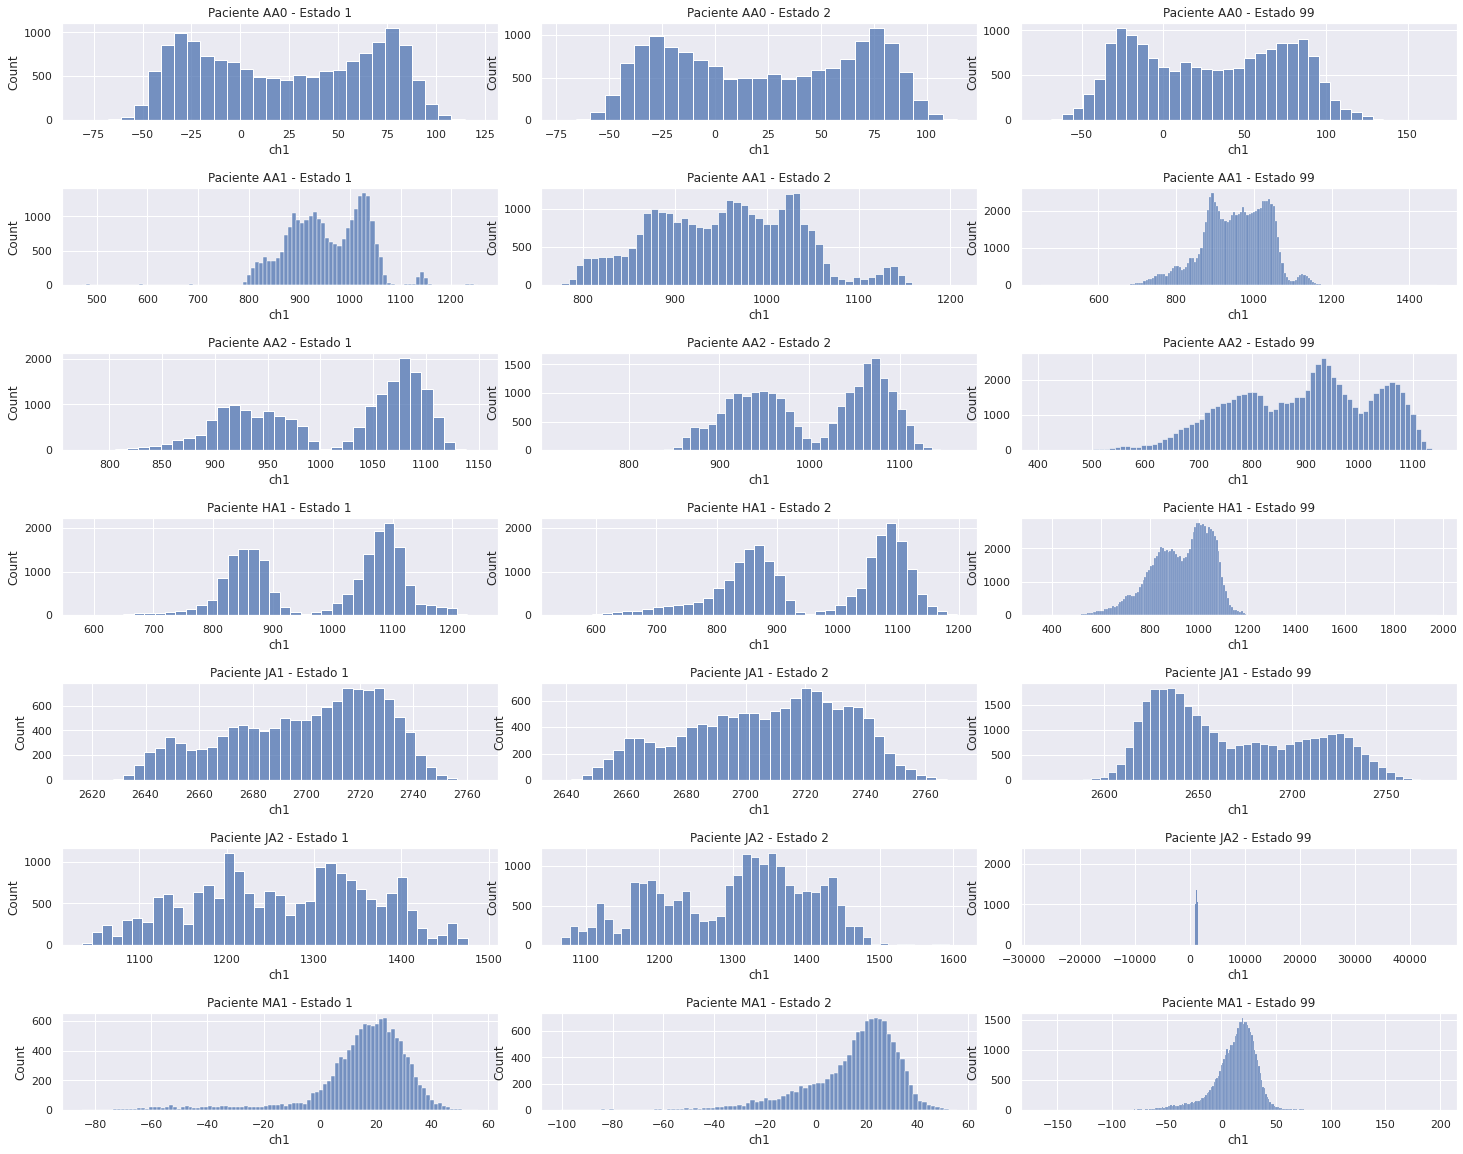

In [ ]:
def label_time(dataframe,label):
  result = dataframe[dataframe.label==label]
  result = result.drop(['time'], axis=1)
  result = result.copy()
  result = result.reset_index()
  result['time'] = result.index.values/200
  return result
dataframes = [(df_AA0, 'AA0'), (df_AA1, 'AA1'), (df_AA2, 'AA2'), (df_HA1,'HA1'), (df_JA1, 'JA1'), (df_JA2, 'JA2'), (df_MA1, 'MA1')]
fig, axes = plt.subplots(ncols=3,nrows=len(dataframes), figsize=(25, 20))
plt.subplots_adjust(wspace=0.1,
hspace=0.7)

for (i,(df,name)) in enumerate(dataframes):
  for j,estado in enumerate([1,2,99]):
    a = sns.histplot(data=label_time(df,estado), x="ch1",ax=axes[i][j])
    a.set_title(f"Paciente {name} - Estado {estado}")
    